#  Análise Completa de Desempenho Acadêmico
## Análise Exploratória, Correlações e Machine Learning

---

**Objetivo:** Analisar dados acadêmicos e criar modelos preditivos para:
- Prever situação do aluno (Aprovado/Reprovado)
- Prever média final
- Identificar perfis de alunos (clustering)
- Extrair insights acionáveis

##  1. Importação de Bibliotecas

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Estatística
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr

# Machine Learning - Pré-processamento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Machine Learning - Modelos de Classificação
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Machine Learning - Modelos de Regressão
from sklearn.linear_model import LinearRegression

# Machine Learning - Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Machine Learning - Métricas
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, mean_absolute_error,
    silhouette_score, davies_bouldin_score
)

# Configurações
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuração do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print(" Bibliotecas importadas com sucesso!")

 Bibliotecas importadas com sucesso!


##  2. Carregamento e Exploração Inicial dos Dados

In [2]:
# Carregar dados do arquivo TXT (CSV)
df = pd.read_csv('/home/gabriel/Área de Trabalho/hapvida/hapvida-agents/trabalho_mestrado/dados_disciplinas.txt') 

print("="*70)
print(" INFORMAÇÕES GERAIS DA BASE DE DADOS")
print("="*70)
print(f"\n Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
print(f"\n Colunas: {list(df.columns)}")
print(f"\n Tipos de dados:")
print(df.dtypes)
print(f"\n Valores faltantes:")
print(df.isnull().sum())
print(f"\n Primeiras 10 linhas:")
df.head(10)

 INFORMAÇÕES GERAIS DA BASE DE DADOS

 Dimensões: 4642 linhas x 7 colunas

 Colunas: ['MATR_ALUNO', 'ANO', 'PERIODO', 'SITUACAO', 'MEDIA_FINAL', 'NUM_FALTAS', 'DISCIPLINA']

 Tipos de dados:
MATR_ALUNO      int64
ANO             int64
PERIODO         int64
SITUACAO       object
MEDIA_FINAL     int64
NUM_FALTAS      int64
DISCIPLINA      int64
dtype: object

 Valores faltantes:
MATR_ALUNO     0
ANO            0
PERIODO        0
SITUACAO       0
MEDIA_FINAL    0
NUM_FALTAS     0
DISCIPLINA     0
dtype: int64

 Primeiras 10 linhas:


,MATR_ALUNO,ANO,PERIODO,SITUACAO,MEDIA_FINAL,NUM_FALTAS,DISCIPLINA
0,1,2013,1,Aprovado,77,12,2
1,2,2013,1,Reprovado por Frequencia,0,32,1
2,3,2013,1,Reprovado por Frequencia,0,50,4
3,4,2013,2,Aprovado,60,2,2
4,4,2013,2,Aprovado,68,2,5
5,5,2013,2,Aprovado,60,4,2
6,5,2014,2,Aprovado,97,8,4
7,6,2013,1,Reprovado por Frequencia,10,42,4
8,7,2013,1,Reprovado por Frequencia,10,45,2
9,8,2013,2,Equivalencia curricular,-1,-1,4


In [3]:
# Estatísticas descritivas
print("="*70)
print("ESTATÍSTICAS DESCRITIVAS")
print("="*70)
df.describe()

ESTATÍSTICAS DESCRITIVAS


,MATR_ALUNO,ANO,PERIODO,MEDIA_FINAL,NUM_FALTAS,DISCIPLINA
count,4642.00,4642.00,4642.00,4642.00,4642.00,4642.00
mean,422.00,2014.99,1.49,41.60,11.30,3.03
std,218.81,1.44,0.50,33.94,15.47,1.40
min,1.00,2013.00,1.00,-1.00,-1.00,1.00
25%,237.00,2014.00,1.00,3.00,0.00,2.00
50%,407.00,2015.00,1.00,43.00,6.00,3.00
75%,606.00,2016.00,2.00,72.00,16.00,4.00
max,831.00,2017.00,2.00,100.00,78.00,5.00


In [4]:
# Informações sobre situações
print("="*70)
print(" DISTRIBUIÇÃO DAS SITUAÇÕES")
print("="*70)
print(df['SITUACAO'].value_counts())
print(f"\n Percentuais:")
print(df['SITUACAO'].value_counts(normalize=True) * 100)

 DISTRIBUIÇÃO DAS SITUAÇÕES
SITUACAO
Aprovado                    2077
Reprovado                   1117
Reprovado por Frequencia     921
Dispensado                   456
Equivalencia curricular       37
Trancamento parcial           34
Name: count, dtype: int64

 Percentuais:
SITUACAO
Aprovado                   44.74
Reprovado                  24.06
Reprovado por Frequencia   19.84
Dispensado                  9.82
Equivalencia curricular     0.80
Trancamento parcial         0.73
Name: proportion, dtype: float64


##  3. Limpeza e Preparação dos Dados

In [8]:
# Criar uma cópia para trabalhar
df_clean = df.copy()

# ============================================
# 1. ANÁLISE DE VALORES ESPECIAIS (-1)
# ============================================
print(" Verificando valores -1 (situações especiais):")
print(f"MEDIA_FINAL = -1: {(df_clean['MEDIA_FINAL'] == -1).sum()} registros")
print(f"NUM_FALTAS = -1: {(df_clean['NUM_FALTAS'] == -1).sum()} registros")

# Verificar distribuição das situações especiais
print("\n Distribuição das situações especiais:")
situacoes_especiais = ['Dispensado', 'Equivalencia curricular', 'Trancamento parcial']
print(df_clean[df_clean['SITUACAO'].isin(situacoes_especiais)]['SITUACAO'].value_counts())

# ============================================
# 2. VERIFICAÇÃO DE CONSISTÊNCIA
# ============================================
print("\n Verificando consistência dos dados:")

# Situações especiais devem ter -1 (ou não?)
situacoes_especiais_df = df_clean[df_clean['SITUACAO'].isin(situacoes_especiais)]
inconsistente = situacoes_especiais_df[
    (situacoes_especiais_df['MEDIA_FINAL'] != -1) | 
    (situacoes_especiais_df['NUM_FALTAS'] != -1)
]
print(f" Situações especiais SEM -1: {len(inconsistente)} registros")
if len(inconsistente) > 0:
    print(inconsistente[['MATR_ALUNO', 'SITUACAO', 'MEDIA_FINAL', 'NUM_FALTAS']].head())

# Valores -1 em situações normais (possível erro)
normal_com_menos1 = df_clean[
    ~df_clean['SITUACAO'].isin(situacoes_especiais) & 
    ((df_clean['MEDIA_FINAL'] == -1) | (df_clean['NUM_FALTAS'] == -1))
]
print(f" Situações NORMAIS com -1: {len(normal_com_menos1)} registros")
if len(normal_com_menos1) > 0:
    print(normal_com_menos1[['MATR_ALUNO', 'SITUACAO', 'MEDIA_FINAL', 'NUM_FALTAS']].head())

# ============================================
# 3. CRIAR DATASETS
# ============================================
# Criar flag para situações especiais
df_clean['SITUACAO_ESPECIAL'] = df_clean['SITUACAO'].isin(situacoes_especiais)

# Dataset apenas com situações normais
df_normal = df_clean[
    ~df_clean['SITUACAO_ESPECIAL'] & 
    (df_clean['MEDIA_FINAL'] >= 0) & 
    (df_clean['NUM_FALTAS'] >= 0)
].copy()

print(f"\n Dataset original: {len(df_clean)} registros")
print(f" Dataset para análise: {len(df_normal)} registros")
print(f" Registros removidos: {len(df_clean) - len(df_normal)} ({((len(df_clean) - len(df_normal))/len(df_clean)*100):.1f}%)")

# ============================================
# 4. VERIFICAÇÃO FINAL DE QUALIDADE
# ============================================
print("\n Verificação final do dataset limpo:")
print(f"Valores negativos em MEDIA_FINAL: {(df_normal['MEDIA_FINAL'] < 0).sum()}")
print(f"Valores negativos em NUM_FALTAS: {(df_normal['NUM_FALTAS'] < 0).sum()}")
print(f"Valores nulos: {df_normal.isnull().sum().sum()}")

print("\n Estatísticas do dataset limpo:")
print(df_normal[['MEDIA_FINAL', 'NUM_FALTAS']].describe())

# ============================================
# 5. DISTRIBUIÇÃO DE SITUAÇÕES (dataset limpo)
# ============================================
print("\n Distribuição de situações no dataset limpo:")
print(df_normal['SITUACAO'].value_counts())

 Verificando valores -1 (situações especiais):
MEDIA_FINAL = -1: 525 registros
NUM_FALTAS = -1: 527 registros

 Distribuição das situações especiais:
SITUACAO
Dispensado                 456
Equivalencia curricular     37
Trancamento parcial         34
Name: count, dtype: int64

 Verificando consistência dos dados:
 Situações especiais SEM -1: 2 registros
     MATR_ALUNO                 SITUACAO  MEDIA_FINAL  NUM_FALTAS
174          80  Equivalencia curricular           36          -1
175          80  Equivalencia curricular           18          -1
 Situações NORMAIS com -1: 0 registros

 Dataset original: 4642 registros
 Dataset para análise: 4115 registros
 Registros removidos: 527 (11.4%)

 Verificação final do dataset limpo:
Valores negativos em MEDIA_FINAL: 0
Valores negativos em NUM_FALTAS: 0
Valores nulos: 0

 Estatísticas do dataset limpo:
       MEDIA_FINAL  NUM_FALTAS
count      4115.00     4115.00
mean         47.04       12.87
std          32.21       15.76
min           0.

In [ ]:
# Criar variáveis derivadas
print("Criando features derivadas...")

# Simplificar situação para classificação binária
df_normal['APROVADO'] = df_normal['SITUACAO'].apply(
    lambda x: 1 if x == 'Aprovado' else 0
)

# Classificação da situação em categorias
def classificar_situacao(situacao):
    if situacao == 'Aprovado':
        return 'Aprovado'
    elif 'Frequencia' in situacao:
        return 'Reprovado por Frequência'
    else:
        return 'Reprovado por Nota'

df_normal['TIPO_SITUACAO'] = df_normal['SITUACAO'].apply(classificar_situacao)

# Faixa de nota
def faixa_nota(nota):
    if nota >= 90:
        return 'Excelente (90-100)'
    elif nota >= 70:
        return 'Bom (70-89)'
    elif nota >= 60:
        return 'Regular (60-69)'
    else:
        return 'Insuficiente (<60)'

df_normal['FAIXA_NOTA'] = df_normal['MEDIA_FINAL'].apply(faixa_nota)

# Faixa de faltas
def faixa_faltas(faltas):
    if faltas == 0:
        return 'Sem faltas'
    elif faltas <= 5:
        return 'Poucas faltas (1-5)'
    elif faltas <= 15:
        return 'Faltas moderadas (6-15)'
    else:
        return 'Muitas faltas (>15)'

df_normal['FAIXA_FALTAS'] = df_normal['NUM_FALTAS'].apply(faixa_faltas)

print(" Features criadas com sucesso!")
print(f"\nNovas colunas: {[col for col in df_normal.columns if col not in df.columns]}")

🔧 Criando features derivadas...
 Features criadas com sucesso!

Novas colunas: ['SITUACAO_ESPECIAL', 'APROVADO', 'TIPO_SITUACAO', 'FAIXA_NOTA', 'FAIXA_FALTAS']


## 4. Análise Exploratória de Dados (EDA)

### 4.1 Distribuições Gerais

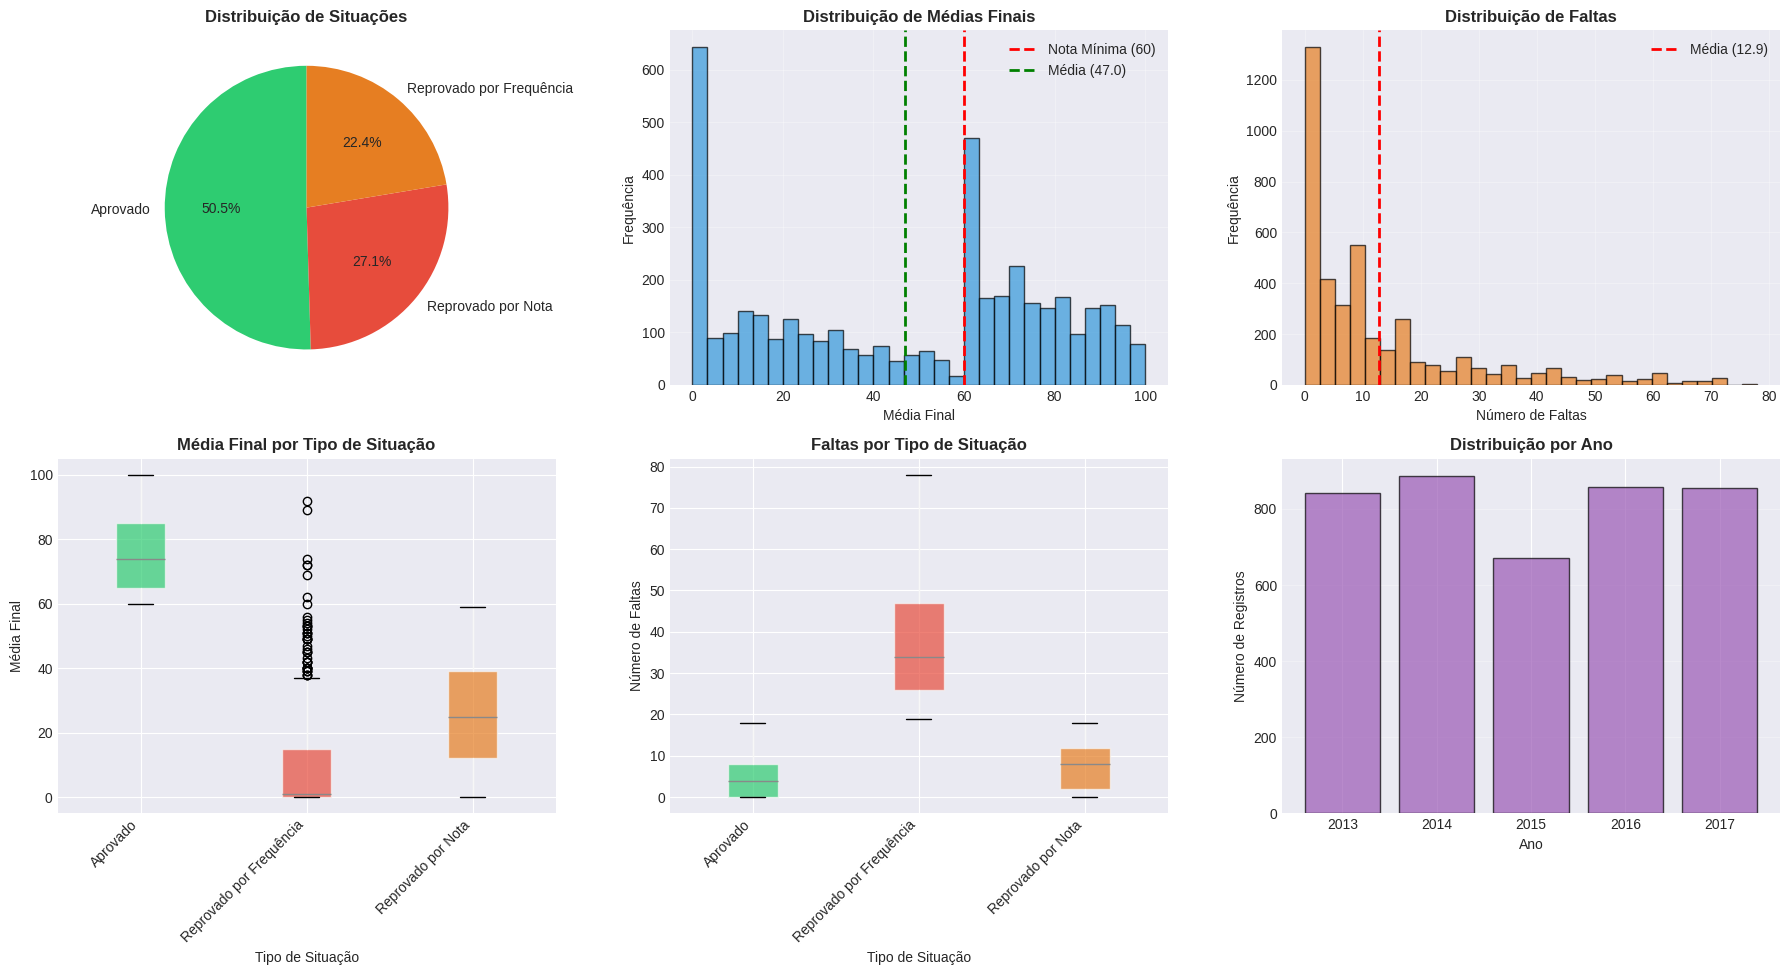

 ESTATÍSTICAS RESUMIDAS

 Média Final:
   - Média: 47.04
   - Mediana: 60.00
   - Desvio Padrão: 32.21

 Faltas:
   - Média: 12.87
   - Mediana: 7.00
   - Desvio Padrão: 15.76


In [15]:
# Criar figura com múltiplos subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(' Análise Exploratória - Distribuições', fontsize=16, fontweight='bold')

# 1. Distribuição de Situações
situacao_counts = df_normal['TIPO_SITUACAO'].value_counts()
colors_situacao = ['#2ecc71', '#e74c3c', '#e67e22']
axes[0, 0].pie(situacao_counts.values, labels=situacao_counts.index, 
               autopct='%1.1f%%', colors=colors_situacao, startangle=90)
axes[0, 0].set_title('Distribuição de Situações', fontweight='bold')

# 2. Distribuição de Notas
axes[0, 1].hist(df_normal['MEDIA_FINAL'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
axes[0, 1].axvline(60, color='red', linestyle='--', linewidth=2, label='Nota Mínima (60)')
axes[0, 1].axvline(df_normal['MEDIA_FINAL'].mean(), color='green', linestyle='--', 
                    linewidth=2, label=f'Média ({df_normal["MEDIA_FINAL"].mean():.1f})')
axes[0, 1].set_xlabel('Média Final')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição de Médias Finais', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribuição de Faltas
axes[0, 2].hist(df_normal['NUM_FALTAS'], bins=30, edgecolor='black', alpha=0.7, color='#e67e22')
axes[0, 2].axvline(df_normal['NUM_FALTAS'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Média ({df_normal["NUM_FALTAS"].mean():.1f})')
axes[0, 2].set_xlabel('Número de Faltas')
axes[0, 2].set_ylabel('Frequência')
axes[0, 2].set_title('Distribuição de Faltas', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Boxplot de Notas por Situação
bp1 = df_normal.boxplot(column='MEDIA_FINAL', by='TIPO_SITUACAO', ax=axes[1, 0], 
                         patch_artist=True, return_type='dict')
axes[1, 0].set_title('Média Final por Tipo de Situação', fontweight='bold')
axes[1, 0].set_xlabel('Tipo de Situação')
axes[1, 0].set_ylabel('Média Final')
axes[1, 0].get_figure().suptitle('')  # Remove o título automático do pandas
plt.sca(axes[1, 0])
plt.xticks(rotation=45, ha='right')

# Colorir os boxplots
for patch, color in zip(bp1['MEDIA_FINAL']['boxes'], colors_situacao):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# 5. Boxplot de Faltas por Situação
bp2 = df_normal.boxplot(column='NUM_FALTAS', by='TIPO_SITUACAO', ax=axes[1, 1], 
                         patch_artist=True, return_type='dict')
axes[1, 1].set_title('Faltas por Tipo de Situação', fontweight='bold')
axes[1, 1].set_xlabel('Tipo de Situação')
axes[1, 1].set_ylabel('Número de Faltas')
axes[1, 1].get_figure().suptitle('')  # Remove o título automático do pandas
plt.sca(axes[1, 1])
plt.xticks(rotation=45, ha='right')

# Colorir os boxplots
for patch, color in zip(bp2['NUM_FALTAS']['boxes'], colors_situacao):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# 6. Distribuição por Ano
ano_counts = df_normal['ANO'].value_counts().sort_index()
axes[1, 2].bar(ano_counts.index, ano_counts.values, edgecolor='black', alpha=0.7, color='#9b59b6')
axes[1, 2].set_xlabel('Ano')
axes[1, 2].set_ylabel('Número de Registros')
axes[1, 2].set_title('Distribuição por Ano', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Estatísticas resumidas
print("="*70)
print(" ESTATÍSTICAS RESUMIDAS")
print("="*70)
print(f"\n Média Final:")
print(f"   - Média: {df_normal['MEDIA_FINAL'].mean():.2f}")
print(f"   - Mediana: {df_normal['MEDIA_FINAL'].median():.2f}")
print(f"   - Desvio Padrão: {df_normal['MEDIA_FINAL'].std():.2f}")
print(f"\n Faltas:")
print(f"   - Média: {df_normal['NUM_FALTAS'].mean():.2f}")
print(f"   - Mediana: {df_normal['NUM_FALTAS'].median():.2f}")
print(f"   - Desvio Padrão: {df_normal['NUM_FALTAS'].std():.2f}")

### 4.2 Análise por Disciplina

 ANÁLISE POR DISCIPLINA
            Total_Registros  Media_Nota  Media_Faltas  Taxa_Aprovacao
DISCIPLINA                                                           
2                      1071       39.09         15.89           38.00
5                       863       37.70         10.75           41.00
4                       831       43.22         14.22           44.00
3                       693       59.17         10.13           70.00
1                       657       64.30         11.94           72.00


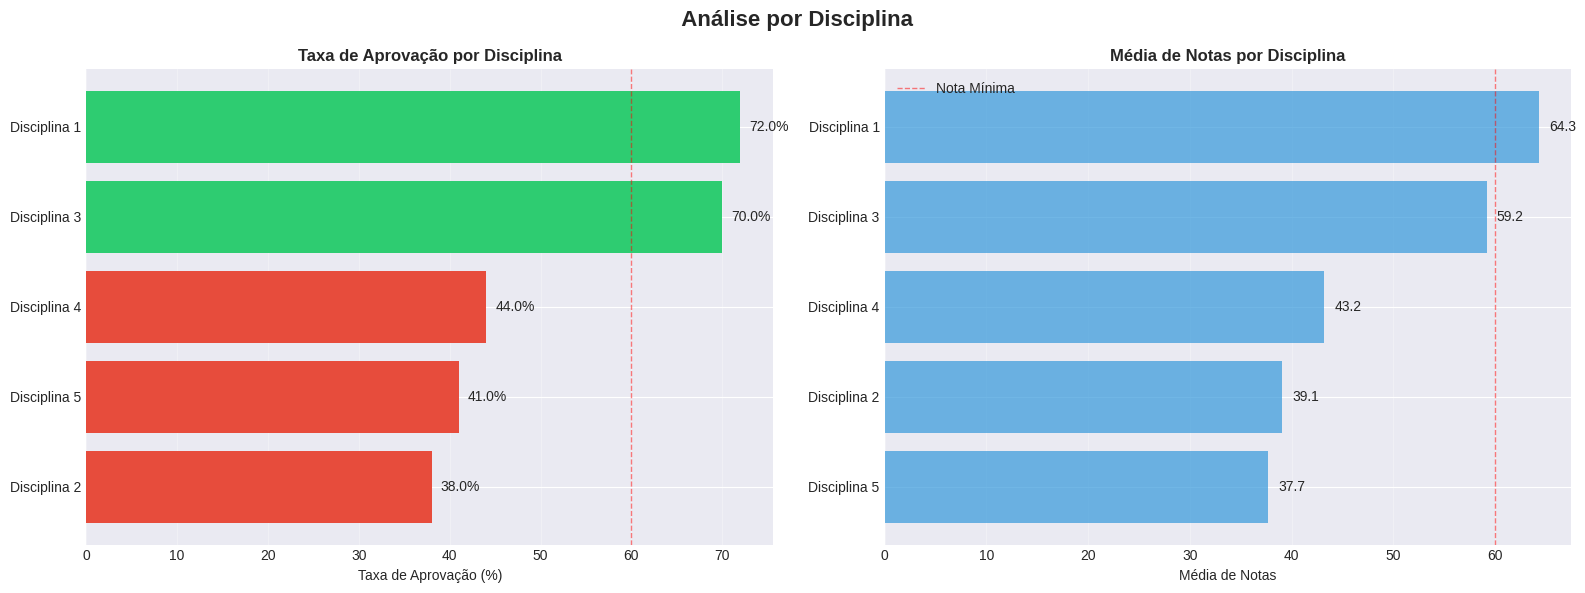

In [12]:
# Análise por disciplina
disciplina_stats = df_normal.groupby('DISCIPLINA').agg({
    'MATR_ALUNO': 'count',
    'MEDIA_FINAL': 'mean',
    'NUM_FALTAS': 'mean',
    'APROVADO': 'mean'
}).round(2)

disciplina_stats.columns = ['Total_Registros', 'Media_Nota', 'Media_Faltas', 'Taxa_Aprovacao']
disciplina_stats['Taxa_Aprovacao'] = (disciplina_stats['Taxa_Aprovacao'] * 100).round(1)
disciplina_stats = disciplina_stats.sort_values('Taxa_Aprovacao')

print("="*70)
print(" ANÁLISE POR DISCIPLINA")
print("="*70)
print(disciplina_stats)

# Gráfico de barras - Taxa de aprovação por disciplina
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(' Análise por Disciplina', fontsize=16, fontweight='bold')

# Taxa de aprovação
colors = ['#e74c3c' if x < 50 else '#f39c12' if x < 70 else '#2ecc71' 
          for x in disciplina_stats['Taxa_Aprovacao']]
axes[0].barh(range(len(disciplina_stats)), disciplina_stats['Taxa_Aprovacao'], color=colors)
axes[0].set_yticks(range(len(disciplina_stats)))
axes[0].set_yticklabels([f'Disciplina {i}' for i in disciplina_stats.index])
axes[0].set_xlabel('Taxa de Aprovação (%)')
axes[0].set_title('Taxa de Aprovação por Disciplina', fontweight='bold')
axes[0].axvline(60, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='x')

# Adicionar valores nas barras
for i, v in enumerate(disciplina_stats['Taxa_Aprovacao']):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center')

# Média de nota por disciplina
disciplina_stats_sorted = disciplina_stats.sort_values('Media_Nota')
axes[1].barh(range(len(disciplina_stats_sorted)), disciplina_stats_sorted['Media_Nota'], 
             color='#3498db', alpha=0.7)
axes[1].set_yticks(range(len(disciplina_stats_sorted)))
axes[1].set_yticklabels([f'Disciplina {i}' for i in disciplina_stats_sorted.index])
axes[1].set_xlabel('Média de Notas')
axes[1].set_title('Média de Notas por Disciplina', fontweight='bold')
axes[1].axvline(60, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Nota Mínima')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].legend()

# Adicionar valores nas barras
for i, v in enumerate(disciplina_stats_sorted['Media_Nota']):
    axes[1].text(v + 1, i, f'{v:.1f}', va='center')

plt.tight_layout()
plt.show()

### 4.3 Análise Temporal

In [17]:
temporal_stats = df_normal.groupby(['ANO', 'PERIODO']).agg({
    'MATR_ALUNO': 'count',
    'APROVADO': 'mean',
    'MEDIA_FINAL': 'mean',
    'NUM_FALTAS': 'mean'
}).reset_index()

temporal_stats.columns = ['ANO', 'PERIODO', 'Total', 'Taxa_Aprovacao', 'Media_Nota', 'Media_Faltas']
temporal_stats['Taxa_Aprovacao'] = (temporal_stats['Taxa_Aprovacao'] * 100).round(1)

print(" temporal_stats criado:")
print(temporal_stats.head())



 temporal_stats criado:
    ANO  PERIODO  Total  Taxa_Aprovacao  Media_Nota  Media_Faltas
0  2013        1    445           49.00       49.23         15.01
1  2013        2    398           38.70       39.33         21.03
2  2014        1    407           45.90       45.98         15.93
3  2014        2    481           46.80       46.24         12.23
4  2015        1    361           61.80       55.99         14.80


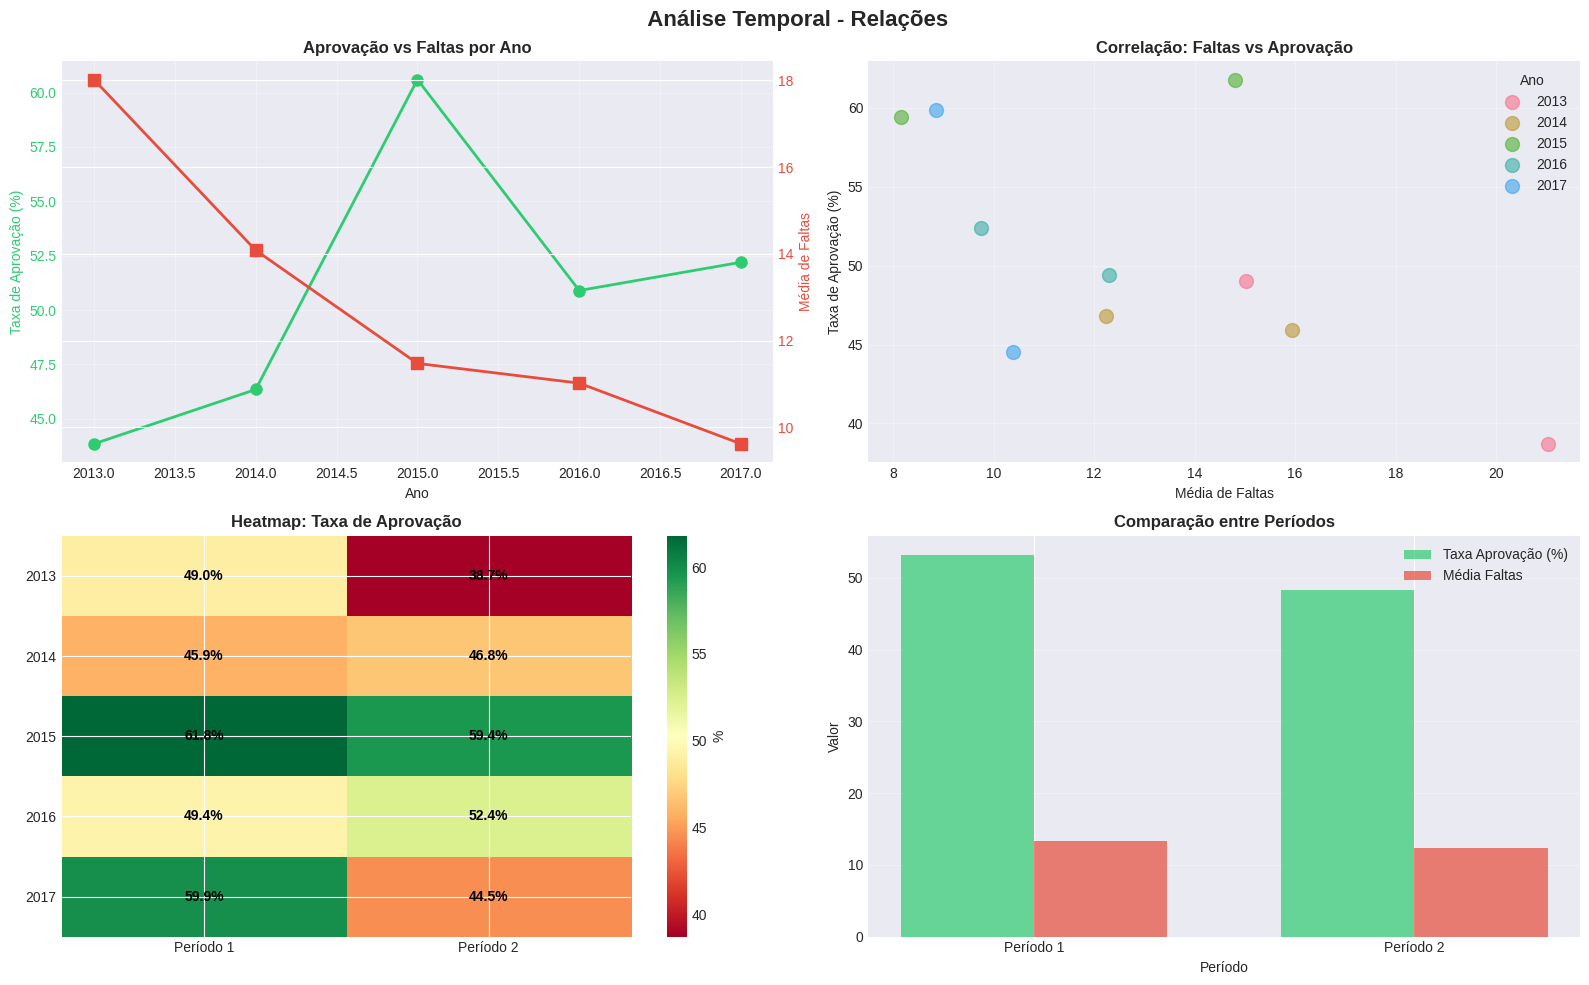


 CORRELAÇÃO TEMPORAL:
Correlação Aprovação x Faltas: -0.597


In [19]:
# Análise temporal com comparação direta
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(' Análise Temporal - Relações', fontsize=16, fontweight='bold')

# 1. APROVAÇÃO vs FALTAS (mesmo gráfico, eixos diferentes)
ax1 = axes[0, 0]
ax2 = ax1.twinx()

# Taxa de aprovação
anos = temporal_stats.groupby('ANO')['Taxa_Aprovacao'].mean()
ax1.plot(anos.index, anos.values, 'o-', color='#2ecc71', linewidth=2, 
         markersize=8, label='Taxa Aprovação')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Taxa de Aprovação (%)', color='#2ecc71')
ax1.tick_params(axis='y', labelcolor='#2ecc71')

# Média de faltas
faltas = temporal_stats.groupby('ANO')['Media_Faltas'].mean()
ax2.plot(faltas.index, faltas.values, 's-', color='#e74c3c', linewidth=2, 
         markersize=8, label='Média Faltas')
ax2.set_ylabel('Média de Faltas', color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

axes[0, 0].set_title('Aprovação vs Faltas por Ano', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. SCATTER: Correlação faltas x aprovação
for ano in temporal_stats['ANO'].unique():
    dados_ano = temporal_stats[temporal_stats['ANO'] == ano]
    axes[0, 1].scatter(dados_ano['Media_Faltas'], dados_ano['Taxa_Aprovacao'], 
                      s=100, alpha=0.6, label=ano)

axes[0, 1].set_xlabel('Média de Faltas')
axes[0, 1].set_ylabel('Taxa de Aprovação (%)')
axes[0, 1].set_title('Correlação: Faltas vs Aprovação', fontweight='bold')
axes[0, 1].legend(title='Ano')
axes[0, 1].grid(True, alpha=0.3)

# 3. HEATMAP por ano
pivot_aprovacao = temporal_stats.pivot(index='ANO', columns='PERIODO', values='Taxa_Aprovacao')
im = axes[1, 0].imshow(pivot_aprovacao, cmap='RdYlGn', aspect='auto')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Período 1', 'Período 2'])
axes[1, 0].set_yticks(range(len(pivot_aprovacao.index)))
axes[1, 0].set_yticklabels(pivot_aprovacao.index)
axes[1, 0].set_title('Heatmap: Taxa de Aprovação', fontweight='bold')
plt.colorbar(im, ax=axes[1, 0], label='%')

# Adicionar valores no heatmap
for i in range(len(pivot_aprovacao.index)):
    for j in range(len(pivot_aprovacao.columns)):
        axes[1, 0].text(j, i, f'{pivot_aprovacao.iloc[i, j]:.1f}%',
                       ha="center", va="center", color="black", fontweight='bold')

# 4. COMPARAÇÃO por período
periodos = temporal_stats.groupby('PERIODO').agg({
    'Taxa_Aprovacao': 'mean',
    'Media_Faltas': 'mean'
})

x = np.arange(len(periodos))
width = 0.35

axes[1, 1].bar(x - width/2, periodos['Taxa_Aprovacao'], width, 
              label='Taxa Aprovação (%)', color='#2ecc71', alpha=0.7)
axes[1, 1].bar(x + width/2, periodos['Media_Faltas'], width, 
              label='Média Faltas', color='#e74c3c', alpha=0.7)

axes[1, 1].set_xlabel('Período')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].set_title('Comparação entre Períodos', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['Período 1', 'Período 2'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Estatísticas
print("\n CORRELAÇÃO TEMPORAL:")
corr = temporal_stats[['Taxa_Aprovacao', 'Media_Faltas']].corr()
print(f"Correlação Aprovação x Faltas: {corr.iloc[0,1]:.3f}")

### 4.4 Análise de Correlação

 ANÁLISE DE CORRELAÇÃO

 Matriz de Correlação:
             MEDIA_FINAL  NUM_FALTAS  DISCIPLINA   ANO  PERIODO  APROVADO
MEDIA_FINAL         1.00       -0.63       -0.18  0.01    -0.06      0.89
NUM_FALTAS         -0.63        1.00       -0.05 -0.18    -0.03     -0.53
DISCIPLINA         -0.18       -0.05        1.00 -0.01     0.05     -0.13
ANO                 0.01       -0.18       -0.01  1.00    -0.02      0.06
PERIODO            -0.06       -0.03        0.05 -0.02     1.00     -0.05
APROVADO            0.89       -0.53       -0.13  0.06    -0.05      1.00


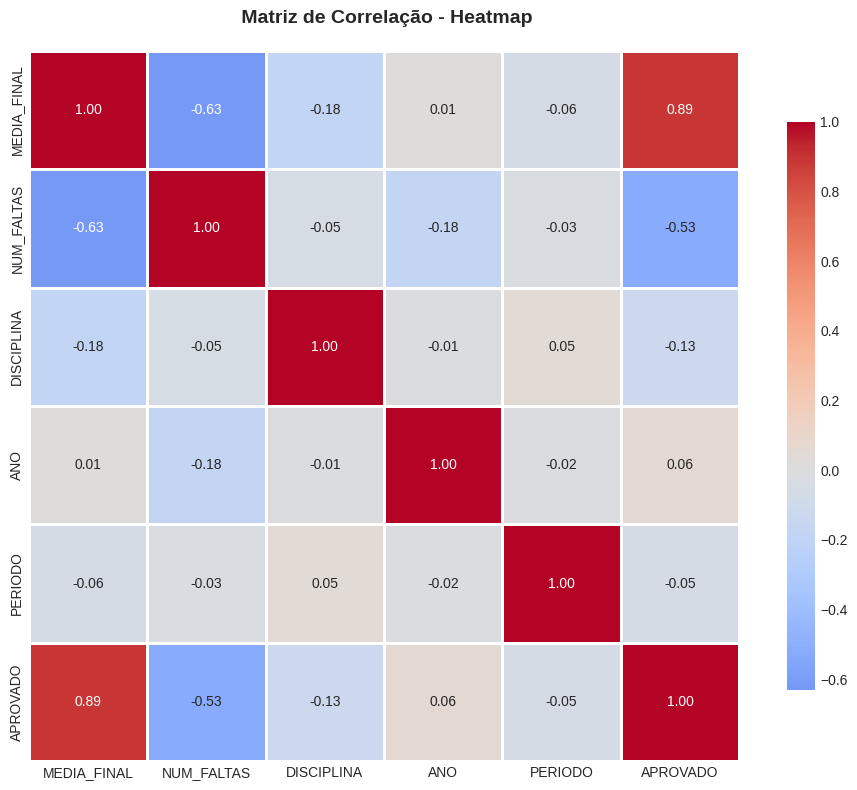


 Principais Correlações:
   • MEDIA_FINAL vs NUM_FALTAS: -0.632
   • MEDIA_FINAL vs APROVADO: 0.886
   • NUM_FALTAS vs APROVADO: -0.526


In [20]:
# Calcular matriz de correlação
print("="*70)
print(" ANÁLISE DE CORRELAÇÃO")
print("="*70)

# Selecionar apenas colunas numéricas
colunas_numericas = ['MEDIA_FINAL', 'NUM_FALTAS', 'DISCIPLINA', 'ANO', 'PERIODO', 'APROVADO']
correlation_matrix = df_normal[colunas_numericas].corr()

print("\n Matriz de Correlação:")
print(correlation_matrix.round(3))

# Heatmap de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title(' Matriz de Correlação - Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlações mais fortes
print("\n Principais Correlações:")
print(f"   • MEDIA_FINAL vs NUM_FALTAS: {correlation_matrix.loc['MEDIA_FINAL', 'NUM_FALTAS']:.3f}")
print(f"   • MEDIA_FINAL vs APROVADO: {correlation_matrix.loc['MEDIA_FINAL', 'APROVADO']:.3f}")
print(f"   • NUM_FALTAS vs APROVADO: {correlation_matrix.loc['NUM_FALTAS', 'APROVADO']:.3f}")

### 4.5 Gráfico de Dispersão (Scatter Plot)

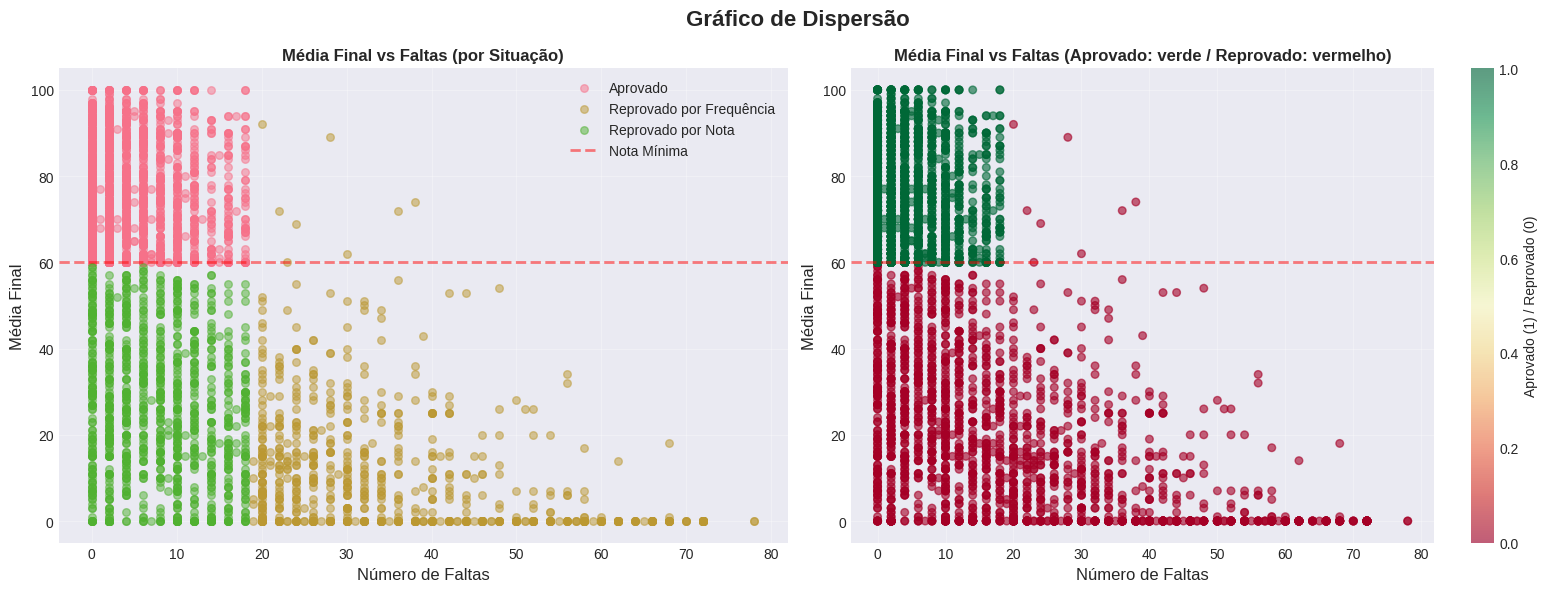

In [21]:
# Scatter plot - Nota vs Faltas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(' Gráfico de Dispersão', fontsize=16, fontweight='bold')

# Plot 1: Por situação
for situacao in df_normal['TIPO_SITUACAO'].unique():
    dados = df_normal[df_normal['TIPO_SITUACAO'] == situacao]
    axes[0].scatter(dados['NUM_FALTAS'], dados['MEDIA_FINAL'], 
                   alpha=0.5, s=30, label=situacao)

axes[0].axhline(60, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Nota Mínima')
axes[0].set_xlabel('Número de Faltas', fontsize=12)
axes[0].set_ylabel('Média Final', fontsize=12)
axes[0].set_title('Média Final vs Faltas (por Situação)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Densidade
scatter = axes[1].scatter(df_normal['NUM_FALTAS'], df_normal['MEDIA_FINAL'], 
                         c=df_normal['APROVADO'], cmap='RdYlGn', alpha=0.6, s=30)
axes[1].axhline(60, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_xlabel('Número de Faltas', fontsize=12)
axes[1].set_ylabel('Média Final', fontsize=12)
axes[1].set_title('Média Final vs Faltas (Aprovado: verde / Reprovado: vermelho)', fontweight='bold')
plt.colorbar(scatter, ax=axes[1], label='Aprovado (1) / Reprovado (0)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  5. Análise de Perfis de Alunos

In [24]:
# Criar perfis agregados por aluno
perfil_alunos = df_normal.groupby('MATR_ALUNO').agg({
    'MEDIA_FINAL': ['mean', 'std', 'min', 'max'],
    'NUM_FALTAS': ['mean', 'sum', 'max'],
    'APROVADO': ['mean', 'sum'],
    'DISCIPLINA': 'count'
}).reset_index()

# Renomear colunas
perfil_alunos.columns = ['MATR_ALUNO', 'media_nota_media', 'media_nota_std', 'nota_min', 'nota_max',
                         'faltas_media', 'faltas_total', 'faltas_max',
                         'taxa_aprovacao', 'total_aprovacoes', 'total_disciplinas']

# Criar categorias de desempenho
def categorizar_desempenho(taxa):
    if taxa >= 0.9:
        return 'Excelente'   # >= 90% aprovações
    elif taxa >= 0.7:
        return 'Bom'         # 70-89% aprovações
    elif taxa >= 0.6:
        return 'Regular'     # 60-69% aprovações ← MUDANÇA AQUI
    else:
        return 'Crítico'     # < 60% aprovações

perfil_alunos['categoria_desempenho'] = perfil_alunos['taxa_aprovacao'].apply(categorizar_desempenho)


print("="*70)
print(" PERFIL DOS ALUNOS")
print("="*70)
print(f"\n Total de alunos únicos: {len(perfil_alunos)}")
print(f"\n Distribuição por categoria de desempenho:")
print(perfil_alunos['categoria_desempenho'].value_counts())
print(f"\n Estatísticas gerais:")
print(perfil_alunos[['media_nota_media', 'faltas_media', 'taxa_aprovacao', 'total_disciplinas']].describe())

 PERFIL DOS ALUNOS

 Total de alunos únicos: 781

 Distribuição por categoria de desempenho:
categoria_desempenho
Crítico      394
Excelente    260
Bom           83
Regular       44
Name: count, dtype: int64

 Estatísticas gerais:
       media_nota_media  faltas_media  taxa_aprovacao  total_disciplinas
count            781.00        781.00          781.00             781.00
mean              49.82         12.89            0.55               5.27
std               26.93         13.58            0.39               2.81
min                0.00          0.00            0.00               1.00
25%               28.80          3.20            0.20               4.00
50%               54.20          8.00            0.57               5.00
75%               72.67         18.00            1.00               7.00
max              100.00         72.00            1.00              20.00


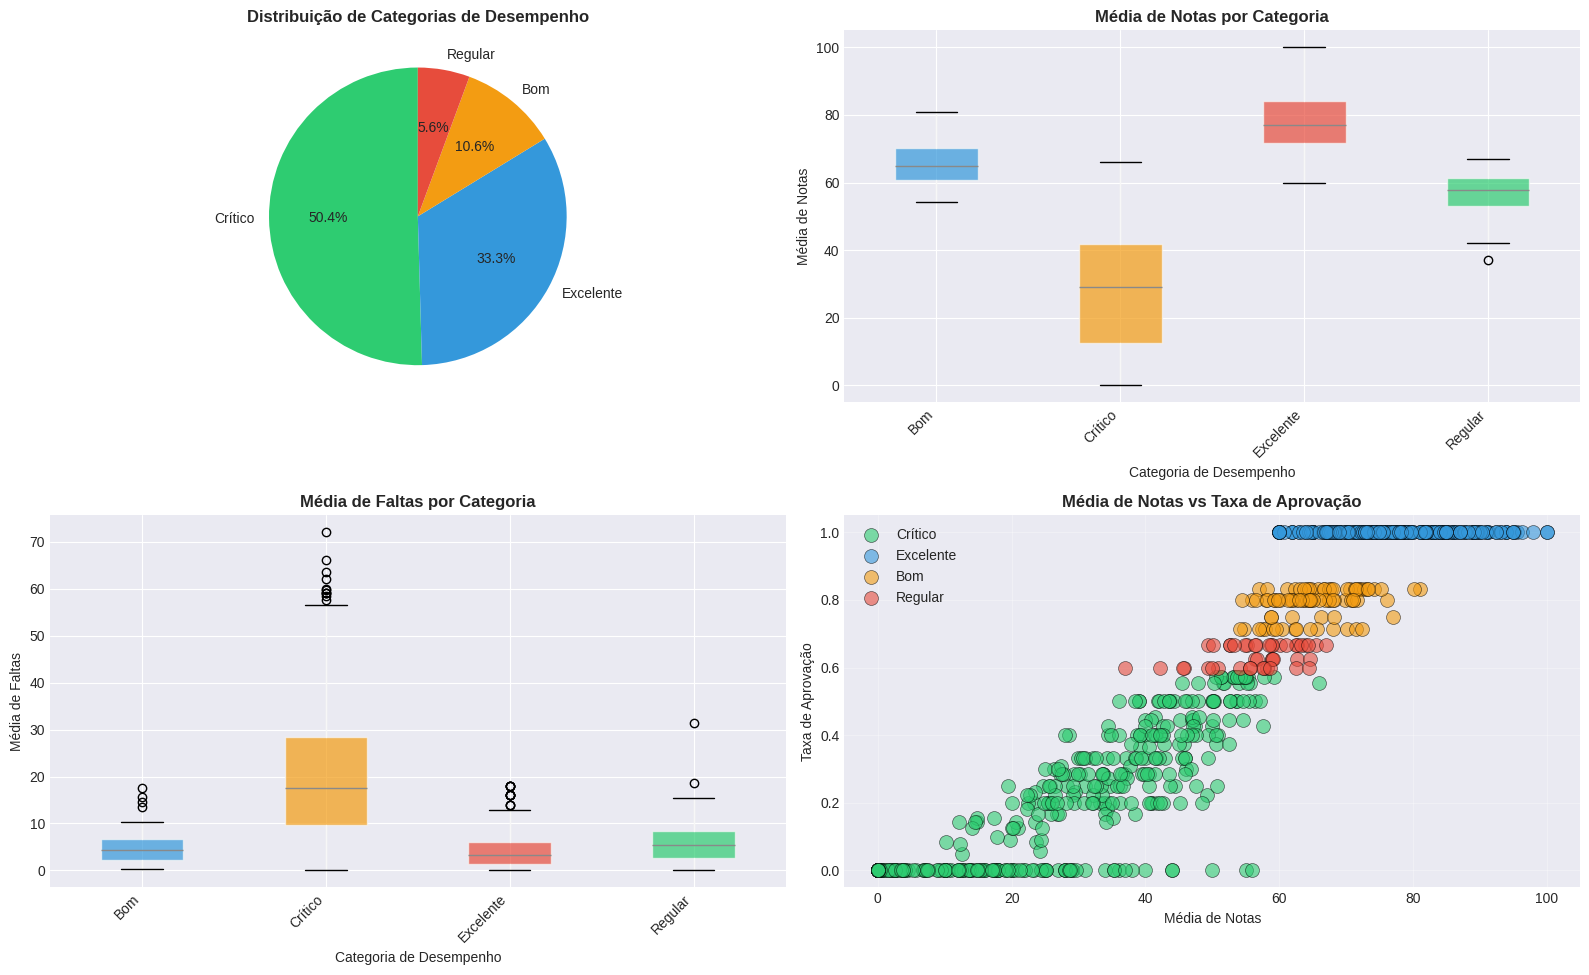

In [28]:
# Visualização dos perfis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(' Análise de Perfis de Alunos', fontsize=16, fontweight='bold')

# Distribuição de categorias
categoria_counts = perfil_alunos['categoria_desempenho'].value_counts()
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
axes[0, 0].pie(categoria_counts.values, labels=categoria_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 0].set_title('Distribuição de Categorias de Desempenho', fontweight='bold')

# Média de notas por categoria
bp1 = perfil_alunos.boxplot(column='media_nota_media', by='categoria_desempenho', 
                             ax=axes[0, 1], patch_artist=True, return_type='dict')
axes[0, 1].set_title('Média de Notas por Categoria', fontweight='bold')
axes[0, 1].set_xlabel('Categoria de Desempenho')
axes[0, 1].set_ylabel('Média de Notas')
axes[0, 1].get_figure().suptitle('')  # Remove título automático
plt.sca(axes[0, 1])
plt.xticks(rotation=45, ha='right')

# Colorir boxplot de notas
categorias_ordenadas = perfil_alunos.groupby('categoria_desempenho')['media_nota_media'].mean().sort_values(ascending=False).index
color_map = dict(zip(categoria_counts.index, colors))
for patch, categoria in zip(bp1['media_nota_media']['boxes'], categorias_ordenadas):
    patch.set_facecolor(color_map.get(categoria, '#95a5a6'))
    patch.set_alpha(0.7)

# Média de faltas por categoria
bp2 = perfil_alunos.boxplot(column='faltas_media', by='categoria_desempenho', 
                             ax=axes[1, 0], patch_artist=True, return_type='dict')
axes[1, 0].set_title('Média de Faltas por Categoria', fontweight='bold')
axes[1, 0].set_xlabel('Categoria de Desempenho')
axes[1, 0].set_ylabel('Média de Faltas')
axes[1, 0].get_figure().suptitle('')  # Remove título automático
plt.sca(axes[1, 0])
plt.xticks(rotation=45, ha='right')

# Colorir boxplot de faltas
for patch, categoria in zip(bp2['faltas_media']['boxes'], categorias_ordenadas):
    patch.set_facecolor(color_map.get(categoria, '#95a5a6'))
    patch.set_alpha(0.7)

# Scatter: Nota média vs Taxa de aprovação
for categoria, color in zip(categoria_counts.index, colors):
    dados = perfil_alunos[perfil_alunos['categoria_desempenho'] == categoria]
    axes[1, 1].scatter(dados['media_nota_media'], dados['taxa_aprovacao'], 
                      alpha=0.6, s=100, label=categoria, color=color, edgecolor='black', linewidth=0.5)

axes[1, 1].set_xlabel('Média de Notas')
axes[1, 1].set_ylabel('Taxa de Aprovação')
axes[1, 1].set_title('Média de Notas vs Taxa de Aprovação', fontweight='bold')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

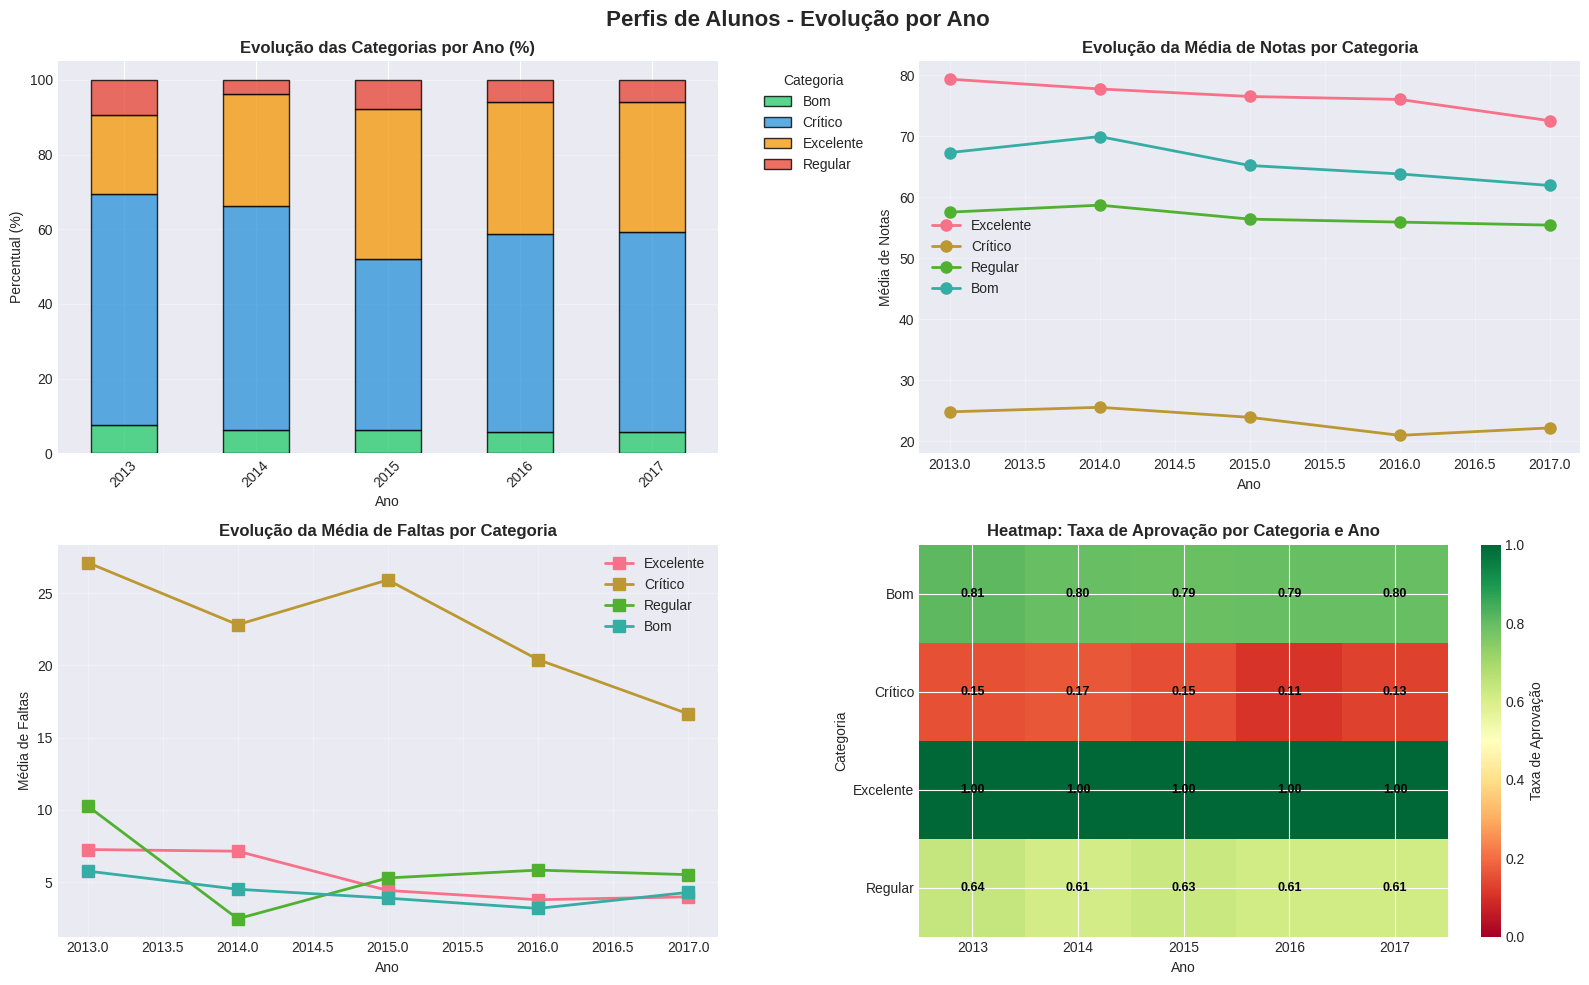

  ESTATÍSTICAS POR ANO

 ANO 2013:
   Total de alunos: 222
   Taxa média de aprovação: 42.9%
   Média de notas: 42.7
   Média de faltas: 19.7

   Distribuição por categoria:
categoria_desempenho
Crítico      137
Excelente     47
Regular       21
Bom           17

 ANO 2014:
   Total de alunos: 237
   Taxa média de aprovação: 47.4%
   Média de notas: 45.2
   Média de faltas: 16.2

   Distribuição por categoria:
categoria_desempenho
Crítico      142
Excelente     71
Bom           15
Regular        9

 ANO 2015:
   Total de alunos: 194
   Taxa média de aprovação: 56.9%
   Média de notas: 50.1
   Média de faltas: 14.3

   Distribuição por categoria:
categoria_desempenho
Crítico      89
Excelente    78
Regular      15
Bom          12

 ANO 2016:
   Total de alunos: 252
   Taxa média de aprovação: 49.2%
   Média de notas: 44.9
   Média de faltas: 12.7

   Distribuição por categoria:
categoria_desempenho
Crítico      134
Excelente     89
Regular       15
Bom           14

 ANO 2017:
   Total 

In [29]:
# ============================================
# CRIAR PERFIS POR ALUNO E ANO
# ============================================
perfil_alunos_ano = df_normal.groupby(['MATR_ALUNO', 'ANO']).agg({
    'MEDIA_FINAL': ['mean', 'std', 'min', 'max'],
    'NUM_FALTAS': ['mean', 'sum', 'max'],
    'APROVADO': ['mean', 'sum'],
    'DISCIPLINA': 'count'
}).reset_index()

# Renomear colunas
perfil_alunos_ano.columns = ['MATR_ALUNO', 'ANO', 'media_nota_media', 'media_nota_std', 
                              'nota_min', 'nota_max', 'faltas_media', 'faltas_total', 
                              'faltas_max', 'taxa_aprovacao', 'total_aprovacoes', 'total_disciplinas']

# Categorizar desempenho
def categorizar_desempenho(taxa):
    if taxa >= 0.9:
        return 'Excelente'
    elif taxa >= 0.7:
        return 'Bom'
    elif taxa >= 0.6:
        return 'Regular'
    else:
        return 'Crítico'

perfil_alunos_ano['categoria_desempenho'] = perfil_alunos_ano['taxa_aprovacao'].apply(categorizar_desempenho)

# ============================================
# VISUALIZAÇÃO POR ANO
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(' Perfis de Alunos - Evolução por Ano', fontsize=16, fontweight='bold')

# 1. EVOLUÇÃO DAS CATEGORIAS POR ANO (stacked bar)
categoria_ano = perfil_alunos_ano.groupby(['ANO', 'categoria_desempenho']).size().unstack(fill_value=0)
categoria_ano_pct = categoria_ano.div(categoria_ano.sum(axis=1), axis=0) * 100

categoria_ano_pct.plot(kind='bar', stacked=True, ax=axes[0, 0], 
                       color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c'],
                       edgecolor='black', alpha=0.8)
axes[0, 0].set_title('Evolução das Categorias por Ano (%)', fontweight='bold')
axes[0, 0].set_xlabel('Ano')
axes[0, 0].set_ylabel('Percentual (%)')
axes[0, 0].legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3, axis='y')
plt.sca(axes[0, 0])
plt.xticks(rotation=45)

# 2. MÉDIA DE NOTAS POR ANO E CATEGORIA
for categoria in perfil_alunos_ano['categoria_desempenho'].unique():
    dados = perfil_alunos_ano[perfil_alunos_ano['categoria_desempenho'] == categoria]
    media_por_ano = dados.groupby('ANO')['media_nota_media'].mean()
    axes[0, 1].plot(media_por_ano.index, media_por_ano.values, 
                   marker='o', linewidth=2, markersize=8, label=categoria)

axes[0, 1].set_xlabel('Ano')
axes[0, 1].set_ylabel('Média de Notas')
axes[0, 1].set_title('Evolução da Média de Notas por Categoria', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. MÉDIA DE FALTAS POR ANO E CATEGORIA
for categoria in perfil_alunos_ano['categoria_desempenho'].unique():
    dados = perfil_alunos_ano[perfil_alunos_ano['categoria_desempenho'] == categoria]
    faltas_por_ano = dados.groupby('ANO')['faltas_media'].mean()
    axes[1, 0].plot(faltas_por_ano.index, faltas_por_ano.values, 
                   marker='s', linewidth=2, markersize=8, label=categoria)

axes[1, 0].set_xlabel('Ano')
axes[1, 0].set_ylabel('Média de Faltas')
axes[1, 0].set_title('Evolução da Média de Faltas por Categoria', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. HEATMAP: Taxa de Aprovação Média por Ano
pivot_taxa = perfil_alunos_ano.groupby(['ANO', 'categoria_desempenho'])['taxa_aprovacao'].mean().unstack()
im = axes[1, 1].imshow(pivot_taxa.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[1, 1].set_xticks(range(len(pivot_taxa.index)))
axes[1, 1].set_xticklabels(pivot_taxa.index)
axes[1, 1].set_yticks(range(len(pivot_taxa.columns)))
axes[1, 1].set_yticklabels(pivot_taxa.columns)
axes[1, 1].set_title('Heatmap: Taxa de Aprovação por Categoria e Ano', fontweight='bold')
axes[1, 1].set_xlabel('Ano')
axes[1, 1].set_ylabel('Categoria')
plt.colorbar(im, ax=axes[1, 1], label='Taxa de Aprovação')

# Adicionar valores no heatmap
for i in range(len(pivot_taxa.columns)):
    for j in range(len(pivot_taxa.index)):
        axes[1, 1].text(j, i, f'{pivot_taxa.iloc[j, i]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================
# ESTATÍSTICAS POR ANO
# ============================================
print("="*80)
print("  ESTATÍSTICAS POR ANO")
print("="*80)

for ano in sorted(perfil_alunos_ano['ANO'].unique()):
    dados_ano = perfil_alunos_ano[perfil_alunos_ano['ANO'] == ano]
    print(f"\n ANO {ano}:")
    print(f"   Total de alunos: {dados_ano['MATR_ALUNO'].nunique()}")
    print(f"   Taxa média de aprovação: {dados_ano['taxa_aprovacao'].mean():.1%}")
    print(f"   Média de notas: {dados_ano['media_nota_media'].mean():.1f}")
    print(f"   Média de faltas: {dados_ano['faltas_media'].mean():.1f}")
    print(f"\n   Distribuição por categoria:")
    print(dados_ano['categoria_desempenho'].value_counts().to_string())

##  6. MACHINE LEARNING - Preparação dos Dados

In [31]:
print("="*70)
print(" PREPARAÇÃO DOS DADOS PARA MODELAGEM")
print("="*70)

# Criar dataset para modelagem
df_ml = df_normal.copy()

# ============================================
# MODELO 1: CLASSIFICAÇÃO - Prever APROVAÇÃO
# ============================================
print("\n MODELO 1: CLASSIFICAÇÃO")
print("   Objetivo: Prever se o aluno será APROVADO com base nas FALTAS")
print("   Caso de uso: Sistema de alerta precoce durante o semestre")

features_class = ['NUM_FALTAS', 'DISCIPLINA', 'ANO', 'PERIODO']
target_class = 'APROVADO'

X_class = df_ml[features_class]
y_class = df_ml[target_class]

print(f"\n   Features: {features_class}")
print(f"   Target: {target_class}")
print(f"   Shape: {X_class.shape}")
print(f"\n   Distribuição do target:")
print(f"   - Aprovado (1): {(y_class == 1).sum()} ({(y_class == 1).sum()/len(y_class)*100:.1f}%)")
print(f"   - Reprovado (0): {(y_class == 0).sum()} ({(y_class == 0).sum()/len(y_class)*100:.1f}%)")

# ============================================
# MODELO 2: REGRESSÃO - Prever NOTA FINAL
# ============================================
print("\n\n MODELO 2: REGRESSÃO")
print("   Objetivo: Prever qual será a NOTA FINAL com base nas FALTAS")
print("   Caso de uso: Estimar desempenho do aluno")

features_reg = ['NUM_FALTAS', 'DISCIPLINA', 'ANO', 'PERIODO']
target_reg = 'MEDIA_FINAL'

X_reg = df_ml[features_reg]
y_reg = df_ml[target_reg]

print(f"\n   Features: {features_reg}")
print(f"   Target: {target_reg}")
print(f"   Shape: {X_reg.shape}")
print(f"\n   Estatísticas do target:")
print(f"   - Média: {y_reg.mean():.2f}")
print(f"   - Mediana: {y_reg.median():.2f}")
print(f"   - Min: {y_reg.min():.2f}")
print(f"   - Max: {y_reg.max():.2f}")
print(f"   - Desvio padrão: {y_reg.std():.2f}")


 PREPARAÇÃO DOS DADOS PARA MODELAGEM

 MODELO 1: CLASSIFICAÇÃO
   Objetivo: Prever se o aluno será APROVADO com base nas FALTAS
   Caso de uso: Sistema de alerta precoce durante o semestre

   Features: ['NUM_FALTAS', 'DISCIPLINA', 'ANO', 'PERIODO']
   Target: APROVADO
   Shape: (4115, 4)

   Distribuição do target:
   - Aprovado (1): 2077 (50.5%)
   - Reprovado (0): 2038 (49.5%)


 MODELO 2: REGRESSÃO
   Objetivo: Prever qual será a NOTA FINAL com base nas FALTAS
   Caso de uso: Estimar desempenho do aluno

   Features: ['NUM_FALTAS', 'DISCIPLINA', 'ANO', 'PERIODO']
   Target: MEDIA_FINAL
   Shape: (4115, 4)

   Estatísticas do target:
   - Média: 47.04
   - Mediana: 60.00
   - Min: 0.00
   - Max: 100.00
   - Desvio padrão: 32.21


##  7. MODELO 1: Classificação - Prever Aprovação/Reprovação

### 7.1 Preparação dos Dados para Classificação

In [33]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Separar features e target para classificação
X_class = df_ml[['NUM_FALTAS', 'DISCIPLINA', 'ANO', 'PERIODO']].copy()
y_class = df_ml['APROVADO'].copy()

# Split treino/teste com estratificação
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.25, random_state=42, stratify=y_class
)

# Normalização (importante para SVM e MLP)
scaler_class = StandardScaler()
X_train_c_scaled = scaler_class.fit_transform(X_train_c)
X_test_c_scaled = scaler_class.transform(X_test_c)

print("="*70)
print(" DADOS PREPARADOS PARA CLASSIFICAÇÃO")
print("="*70)
print(f"\n Treino: {X_train_c.shape[0]} amostras")
print(f" Teste: {X_test_c.shape[0]} amostras")
print(f"\n Distribuição no treino:")
print(f"   Aprovado (1): {(y_train_c == 1).sum()} ({(y_train_c == 1).sum()/len(y_train_c)*100:.1f}%)")
print(f"   Reprovado (0): {(y_train_c == 0).sum()} ({(y_train_c == 0).sum()/len(y_train_c)*100:.1f}%)")
print(f"\n Distribuição no teste:")
print(f"   Aprovado (1): {(y_test_c == 1).sum()} ({(y_test_c == 1).sum()/len(y_test_c)*100:.1f}%)")
print(f"   Reprovado (0): {(y_test_c == 0).sum()} ({(y_test_c == 0).sum()/len(y_test_c)*100:.1f}%)")

 DADOS PREPARADOS PARA CLASSIFICAÇÃO

 Treino: 3086 amostras
 Teste: 1029 amostras

 Distribuição no treino:
   Aprovado (1): 1558 (50.5%)
   Reprovado (0): 1528 (49.5%)

 Distribuição no teste:
   Aprovado (1): 519 (50.4%)
   Reprovado (0): 510 (49.6%)


### 7.2 Treinamento dos Modelos de Classificação

In [34]:
from time import time

# Dicionário para armazenar modelos e resultados
modelos_class = {}
resultados_class = {}
tempos_treinamento = {}

print("="*70)
print(" TREINAMENTO DOS MODELOS DE CLASSIFICAÇÃO")
print("="*70)

# 1. REGRESSÃO LOGÍSTICA
print("\n 1/6 - Treinando Regressão Logística...")
start = time()
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train_c_scaled, y_train_c)
y_pred_lr = lr.predict(X_test_c_scaled)
tempo_lr = time() - start

modelos_class['Logistic Regression'] = lr
resultados_class['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test_c, y_pred_lr),
    'precision': precision_score(y_test_c, y_pred_lr),
    'recall': recall_score(y_test_c, y_pred_lr),
    'f1': f1_score(y_test_c, y_pred_lr)
}
tempos_treinamento['Logistic Regression'] = tempo_lr
print(f"   Acurácia: {resultados_class['Logistic Regression']['accuracy']:.4f} | Tempo: {tempo_lr:.2f}s")

# 2. SVM LINEAR
print("\n 2/6 - Treinando SVM Linear...")
start = time()
svm_linear = SVC(kernel='linear', random_state=42, class_weight='balanced')
svm_linear.fit(X_train_c_scaled, y_train_c)
y_pred_svm_linear = svm_linear.predict(X_test_c_scaled)
tempo_svm_linear = time() - start

modelos_class['SVM Linear'] = svm_linear
resultados_class['SVM Linear'] = {
    'accuracy': accuracy_score(y_test_c, y_pred_svm_linear),
    'precision': precision_score(y_test_c, y_pred_svm_linear),
    'recall': recall_score(y_test_c, y_pred_svm_linear),
    'f1': f1_score(y_test_c, y_pred_svm_linear)
}
tempos_treinamento['SVM Linear'] = tempo_svm_linear
print(f"   Acurácia: {resultados_class['SVM Linear']['accuracy']:.4f} | Tempo: {tempo_svm_linear:.2f}s")

# 3. SVM RBF
print("\n 3/6 - Treinando SVM RBF...")
start = time()
svm_rbf = SVC(kernel='rbf', random_state=42, class_weight='balanced')
svm_rbf.fit(X_train_c_scaled, y_train_c)
y_pred_svm_rbf = svm_rbf.predict(X_test_c_scaled)
tempo_svm_rbf = time() - start

modelos_class['SVM RBF'] = svm_rbf
resultados_class['SVM RBF'] = {
    'accuracy': accuracy_score(y_test_c, y_pred_svm_rbf),
    'precision': precision_score(y_test_c, y_pred_svm_rbf),
    'recall': recall_score(y_test_c, y_pred_svm_rbf),
    'f1': f1_score(y_test_c, y_pred_svm_rbf)
}
tempos_treinamento['SVM RBF'] = tempo_svm_rbf
print(f"   Acurácia: {resultados_class['SVM RBF']['accuracy']:.4f} | Tempo: {tempo_svm_rbf:.2f}s")

# 4. RANDOM FOREST
print("\n 4/6 - Treinando Random Forest...")
start = time()
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train_c, y_train_c)  # Random Forest não precisa de normalização
y_pred_rf = rf.predict(X_test_c)
tempo_rf = time() - start

modelos_class['Random Forest'] = rf
resultados_class['Random Forest'] = {
    'accuracy': accuracy_score(y_test_c, y_pred_rf),
    'precision': precision_score(y_test_c, y_pred_rf),
    'recall': recall_score(y_test_c, y_pred_rf),
    'f1': f1_score(y_test_c, y_pred_rf)
}
tempos_treinamento['Random Forest'] = tempo_rf
print(f"   Acurácia: {resultados_class['Random Forest']['accuracy']:.4f} | Tempo: {tempo_rf:.2f}s")

# 5. XGBOOST
print("\n 5/6 - Treinando XGBoost...")
start = time()
# Calcular scale_pos_weight para balanceamento
scale_pos_weight = (y_train_c == 0).sum() / (y_train_c == 1).sum()
xgb = XGBClassifier(
    n_estimators=100, 
    random_state=42, 
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    n_jobs=-1
)
xgb.fit(X_train_c, y_train_c)  # XGBoost não precisa de normalização
y_pred_xgb = xgb.predict(X_test_c)
tempo_xgb = time() - start

modelos_class['XGBoost'] = xgb
resultados_class['XGBoost'] = {
    'accuracy': accuracy_score(y_test_c, y_pred_xgb),
    'precision': precision_score(y_test_c, y_pred_xgb),
    'recall': recall_score(y_test_c, y_pred_xgb),
    'f1': f1_score(y_test_c, y_pred_xgb)
}
tempos_treinamento['XGBoost'] = tempo_xgb
print(f"   Acurácia: {resultados_class['XGBoost']['accuracy']:.4f} | Tempo: {tempo_xgb:.2f}s")

# 6. REDE NEURAL MLP
print("\n 6/6 - Treinando Rede Neural MLP...")
start = time()
mlp = MLPClassifier(
    hidden_layer_sizes=(20, 10, 5), 
    max_iter=1000, 
    random_state=42, 
    early_stopping=True,
    validation_fraction=0.1
)
mlp.fit(X_train_c_scaled, y_train_c)
y_pred_mlp = mlp.predict(X_test_c_scaled)
tempo_mlp = time() - start

modelos_class['MLP Neural Network'] = mlp
resultados_class['MLP Neural Network'] = {
    'accuracy': accuracy_score(y_test_c, y_pred_mlp),
    'precision': precision_score(y_test_c, y_pred_mlp),
    'recall': recall_score(y_test_c, y_pred_mlp),
    'f1': f1_score(y_test_c, y_pred_mlp)
}
tempos_treinamento['MLP Neural Network'] = tempo_mlp
print(f"    Acurácia: {resultados_class['MLP Neural Network']['accuracy']:.4f} | Tempo: {tempo_mlp:.2f}s")


 TREINAMENTO DOS MODELOS DE CLASSIFICAÇÃO

 1/6 - Treinando Regressão Logística...
   Acurácia: 0.7959 | Tempo: 0.02s

 2/6 - Treinando SVM Linear...
   Acurácia: 0.7959 | Tempo: 0.23s

 3/6 - Treinando SVM RBF...
   Acurácia: 0.8008 | Tempo: 0.33s

 4/6 - Treinando Random Forest...
   Acurácia: 0.8017 | Tempo: 0.44s

 5/6 - Treinando XGBoost...
   Acurácia: 0.7969 | Tempo: 4.16s

 6/6 - Treinando Rede Neural MLP...
    Acurácia: 0.7852 | Tempo: 0.18s


### 7.3 Comparação dos Modelos de Classificação

 COMPARAÇÃO DOS MODELOS DE CLASSIFICAÇÃO
                     accuracy  precision  recall   f1  tempo
SVM RBF                  0.80       0.75    0.91 0.82   0.33
SVM Linear               0.80       0.75    0.89 0.82   0.23
Random Forest            0.80       0.78    0.84 0.81   0.44
Logistic Regression      0.80       0.76    0.86 0.81   0.02
XGBoost                  0.80       0.78    0.84 0.81   4.16
MLP Neural Network       0.79       0.76    0.84 0.80   0.18


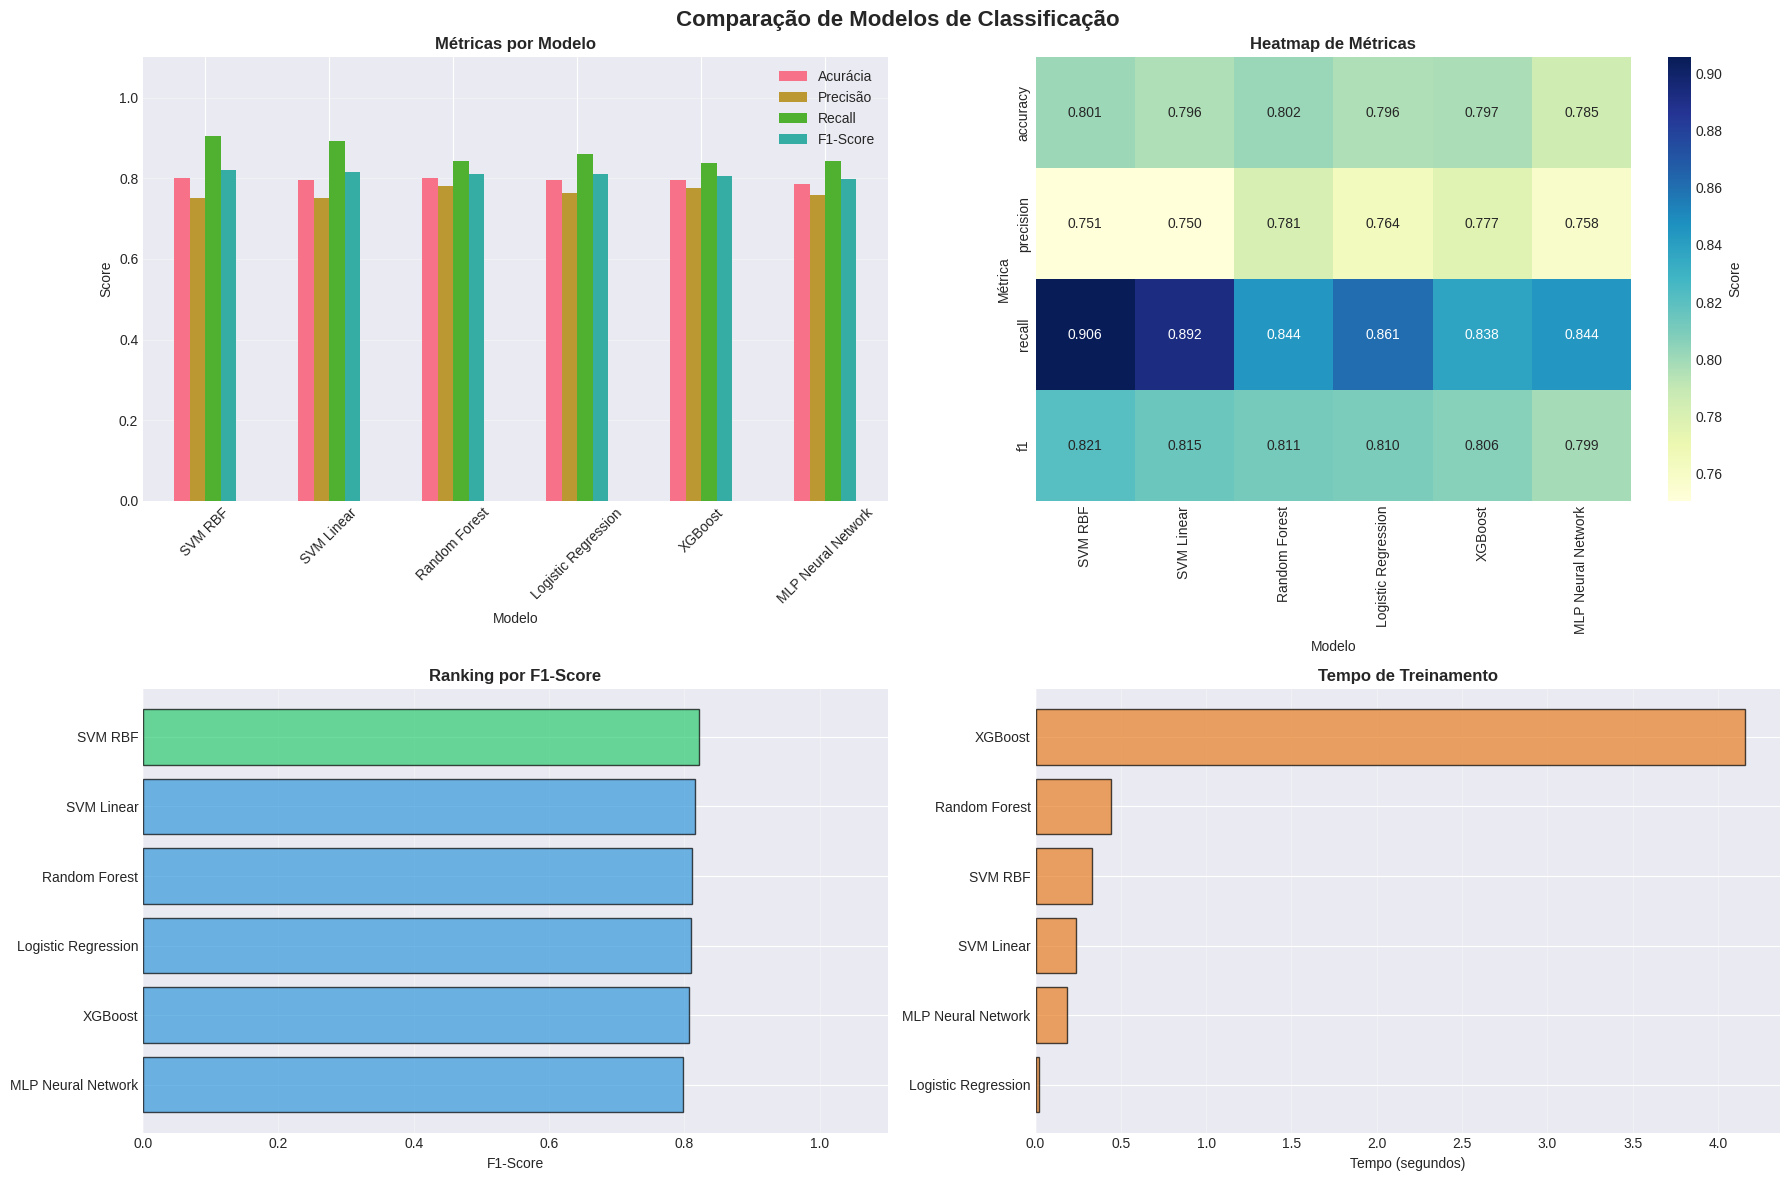


 MELHOR MODELO: SVM RBF
    Acurácia: 0.8008
    Precisão: 0.7508
    Recall: 0.9056
    F1-Score: 0.8210
   ⏱  Tempo: 0.33s


In [ ]:
df_resultados_class = pd.DataFrame(resultados_class).T
df_resultados_class['tempo'] = pd.Series(tempos_treinamento)
df_resultados_class = df_resultados_class.sort_values('f1', ascending=False)

print("="*70)
print(" COMPARAÇÃO DOS MODELOS DE CLASSIFICAÇÃO")
print("="*70)
print(df_resultados_class.round(4))

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(' Comparação de Modelos de Classificação', fontsize=16, fontweight='bold')

# 1. Gráfico de barras com todas as métricas
df_resultados_class[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Métricas por Modelo', fontweight='bold')
axes[0, 0].set_xlabel('Modelo')
axes[0, 0].set_ylabel('Score')
axes[0, 0].legend(['Acurácia', 'Precisão', 'Recall', 'F1-Score'])
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.1])
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Heatmap das métricas
sns.heatmap(df_resultados_class[['accuracy', 'precision', 'recall', 'f1']].T, 
            annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[0, 1], 
            cbar_kws={'label': 'Score'})
axes[0, 1].set_title('Heatmap de Métricas', fontweight='bold')
axes[0, 1].set_xlabel('Modelo')
axes[0, 1].set_ylabel('Métrica')

# 3. Comparação F1-Score (métrica mais importante)
f1_scores = df_resultados_class['f1'].sort_values(ascending=True)
colors = ['#2ecc71' if x == f1_scores.max() else '#3498db' for x in f1_scores]
axes[1, 0].barh(f1_scores.index, f1_scores.values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].set_title('Ranking por F1-Score', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].set_xlim([0, 1.1])

# 4. Tempo de treinamento
tempos = df_resultados_class['tempo'].sort_values()
axes[1, 1].barh(tempos.index, tempos.values, color='#e67e22', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Tempo (segundos)')
axes[1, 1].set_title('Tempo de Treinamento', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Melhor modelo
melhor_modelo_class = df_resultados_class.index[0]
print(f"\n MELHOR MODELO: {melhor_modelo_class}")
print(f"    Acurácia: {df_resultados_class.loc[melhor_modelo_class, 'accuracy']:.4f}")
print(f"    Precisão: {df_resultados_class.loc[melhor_modelo_class, 'precision']:.4f}")
print(f"    Recall: {df_resultados_class.loc[melhor_modelo_class, 'recall']:.4f}")
print(f"    F1-Score: {df_resultados_class.loc[melhor_modelo_class, 'f1']:.4f}")
print(f"    Tempo: {df_resultados_class.loc[melhor_modelo_class, 'tempo']:.2f}s")

### 7.4 Matriz de Confusão do Melhor Modelo

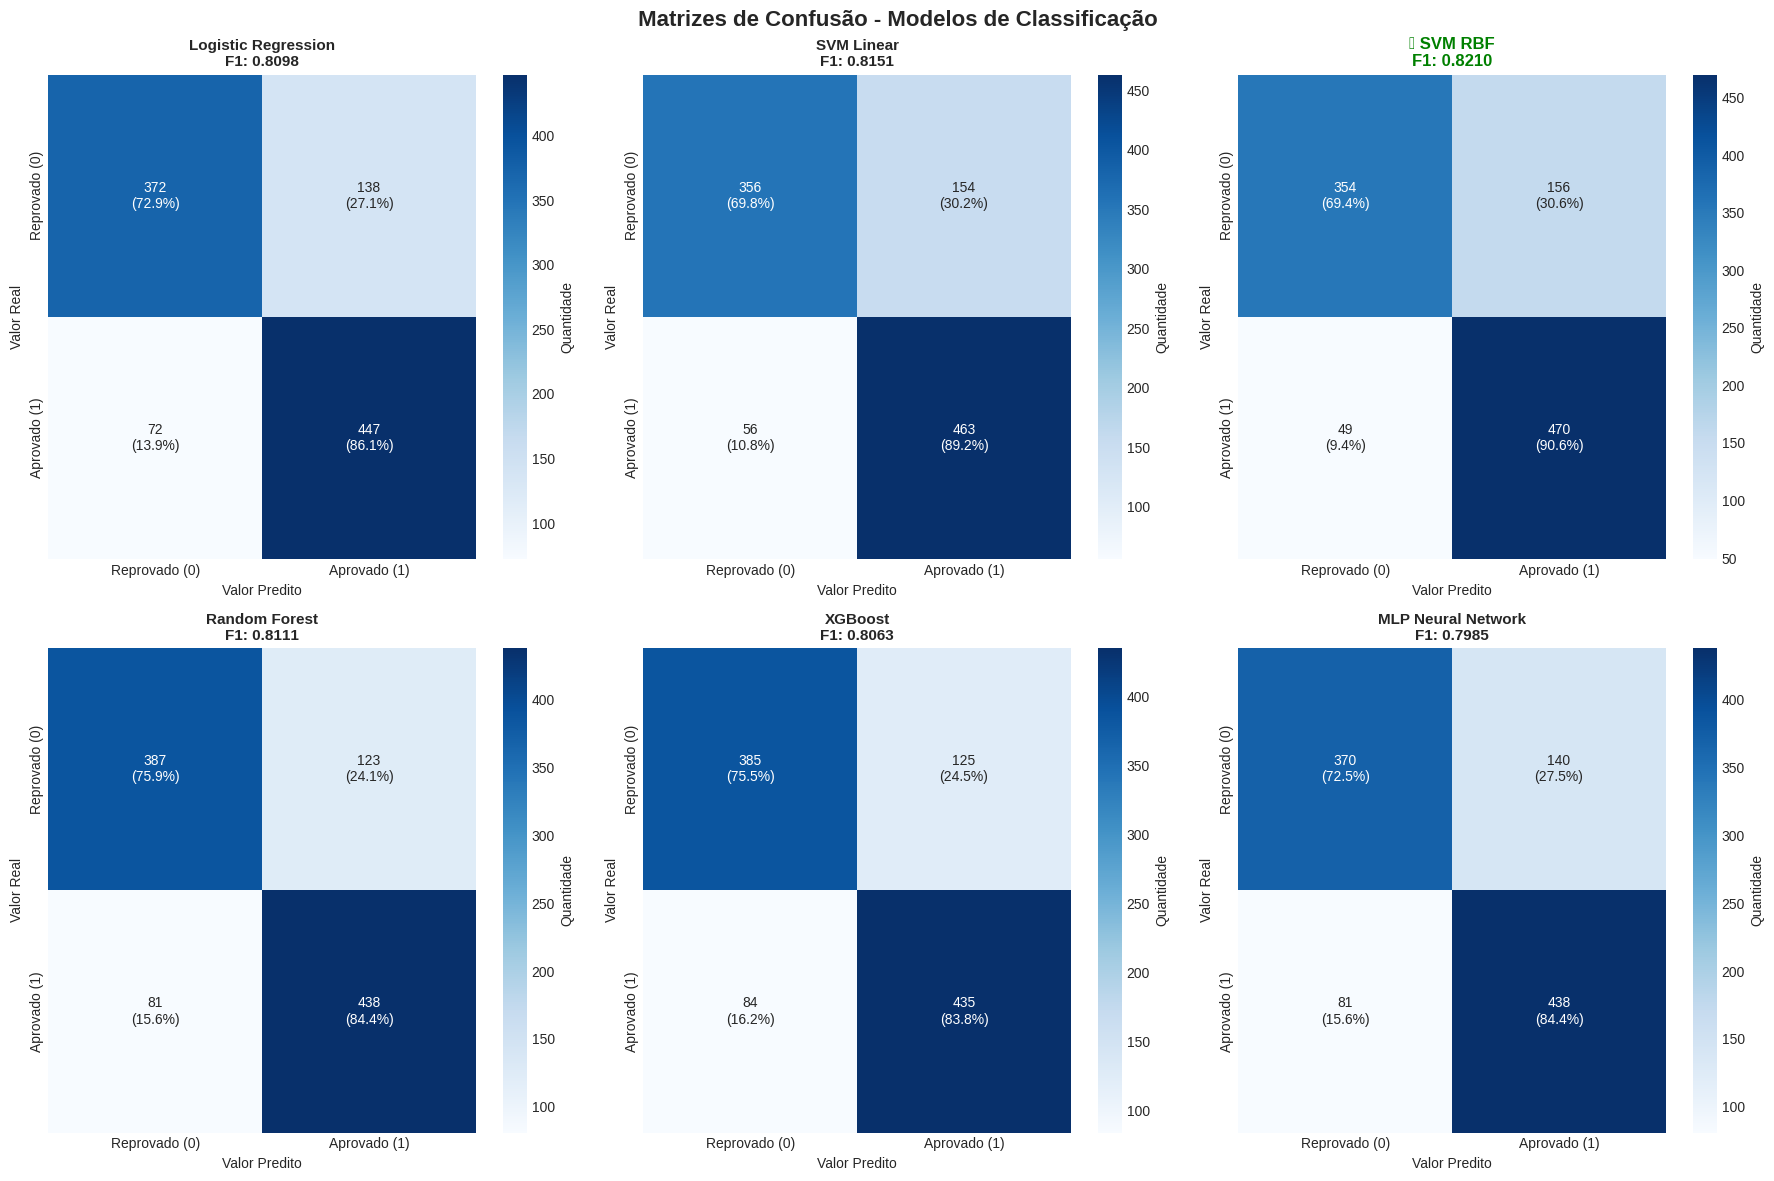


 ANÁLISE DE ERROS (Melhor Modelo)

 Verdadeiros Negativos (TN): 354 - Reprovados corretamente identificados
 Falsos Positivos (FP): 156 - Reprovados classificados como aprovados
 Falsos Negativos (FN): 49 - Aprovados classificados como reprovados
 Verdadeiros Positivos (TP): 470 - Aprovados corretamente identificados

 Taxa de Falsos Positivos: 30.59% (CRÍTICO: aprovar quem deveria reprovar)
 Taxa de Falsos Negativos: 9.44% (reprovar quem deveria aprovar)


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(' Matrizes de Confusão - Modelos de Classificação', fontsize=16, fontweight='bold')

predictions = {
    'Logistic Regression': y_pred_lr,
    'SVM Linear': y_pred_svm_linear,
    'SVM RBF': y_pred_svm_rbf,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'MLP Neural Network': y_pred_mlp
}

for idx, (nome, pred) in enumerate(predictions.items()):
    ax = axes[idx // 3, idx % 3]
    cm = confusion_matrix(y_test_c, pred)
    
    # Adicionar percentuais
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    labels = [[f'{valor}\n({pct:.1f}%)' for valor, pct in zip(row_cm, row_pct)] 
              for row_cm, row_pct in zip(cm, cm_percent)]
    
    sns.heatmap(cm, annot=np.array(labels), fmt='', cmap='Blues', ax=ax, 
                xticklabels=['Reprovado (0)', 'Aprovado (1)'],
                yticklabels=['Reprovado (0)', 'Aprovado (1)'],
                cbar_kws={'label': 'Quantidade'})
    
    # Destacar melhor modelo
    if nome == melhor_modelo_class:
        ax.set_title(f' {nome}\nF1: {resultados_class[nome]["f1"]:.4f}', 
                    fontweight='bold', color='green', fontsize=12)
    else:
        ax.set_title(f'{nome}\nF1: {resultados_class[nome]["f1"]:.4f}', 
                    fontweight='bold', fontsize=11)
    
    ax.set_ylabel('Valor Real')
    ax.set_xlabel('Valor Predito')

plt.tight_layout()
plt.show()

# Análise de erros
print("\n" + "="*70)
print(" ANÁLISE DE ERROS (Melhor Modelo)")
print("="*70)
melhor_pred = predictions[melhor_modelo_class]
cm = confusion_matrix(y_test_c, melhor_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n Verdadeiros Negativos (TN): {tn} - Reprovados corretamente identificados")
print(f" Falsos Positivos (FP): {fp} - Reprovados classificados como aprovados")
print(f" Falsos Negativos (FN): {fn} - Aprovados classificados como reprovados")
print(f" Verdadeiros Positivos (TP): {tp} - Aprovados corretamente identificados")

print(f"\n Taxa de Falsos Positivos: {fp/(fp+tn)*100:.2f}% (CRÍTICO: aprovar quem deveria reprovar)")
print(f" Taxa de Falsos Negativos: {fn/(fn+tp)*100:.2f}% (reprovar quem deveria aprovar)")

##  8. MODELO 2: Regressão - Prever Média Final

### 8.1 Preparação dos Dados para Regressão

In [37]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Separar features e target para regressão
X_reg = df_ml[['NUM_FALTAS', 'DISCIPLINA', 'ANO', 'PERIODO']].copy()
y_reg = df_ml['MEDIA_FINAL'].copy()

# Split treino/teste (sem estratificação pois é regressão)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=42
)

# Normalização (importante para SVR e MLP)
scaler_reg = StandardScaler()
X_train_r_scaled = scaler_reg.fit_transform(X_train_r)
X_test_r_scaled = scaler_reg.transform(X_test_r)

print("="*70)
print(" DADOS PREPARADOS PARA REGRESSÃO")
print("="*70)
print(f"\n Treino: {X_train_r.shape[0]} amostras")
print(f" Teste: {X_test_r.shape[0]} amostras")

print(f"\n Estatísticas do target (MEDIA_FINAL) - TREINO:")
print(f"   Média: {y_train_r.mean():.2f}")
print(f"   Desvio Padrão: {y_train_r.std():.2f}")
print(f"   Mínimo: {y_train_r.min():.2f}")
print(f"   Máximo: {y_train_r.max():.2f}")

print(f"\n Estatísticas do target (MEDIA_FINAL) - TESTE:")
print(f"   Média: {y_test_r.mean():.2f}")
print(f"   Desvio Padrão: {y_test_r.std():.2f}")
print(f"   Mínimo: {y_test_r.min():.2f}")
print(f"   Máximo: {y_test_r.max():.2f}")

 DADOS PREPARADOS PARA REGRESSÃO

 Treino: 3086 amostras
 Teste: 1029 amostras

 Estatísticas do target (MEDIA_FINAL) - TREINO:
   Média: 46.70
   Desvio Padrão: 32.13
   Mínimo: 0.00
   Máximo: 100.00

 Estatísticas do target (MEDIA_FINAL) - TESTE:
   Média: 48.08
   Desvio Padrão: 32.47
   Mínimo: 0.00
   Máximo: 100.00


### 8.2 Treinamento dos Modelos de Regressão

In [38]:
from time import time

# Dicionário para armazenar modelos e resultados
modelos_reg = {}
resultados_reg = {}
tempos_treinamento_reg = {}

print("="*70)
print(" TREINAMENTO DOS MODELOS DE REGRESSÃO")
print("="*70)

# 1. REGRESSÃO LINEAR
print("\n 1/6 - Treinando Regressão Linear...")
start = time()
lin_reg = LinearRegression()
lin_reg.fit(X_train_r_scaled, y_train_r)
y_pred_lin = lin_reg.predict(X_test_r_scaled)
tempo_lin = time() - start

modelos_reg['Linear Regression'] = lin_reg
resultados_reg['Linear Regression'] = {
    'R²': r2_score(y_test_r, y_pred_lin),
    'RMSE': np.sqrt(mean_squared_error(y_test_r, y_pred_lin)),
    'MAE': mean_absolute_error(y_test_r, y_pred_lin),
    'MAPE': np.mean(np.abs((y_test_r - y_pred_lin) / y_test_r)) * 100
}
tempos_treinamento_reg['Linear Regression'] = tempo_lin
print(f"    R²: {resultados_reg['Linear Regression']['R²']:.4f} | RMSE: {resultados_reg['Linear Regression']['RMSE']:.2f} | Tempo: {tempo_lin:.2f}s")

# 2. RIDGE REGRESSION (Regularização L2)
print("\n 2/6 - Treinando Ridge Regression...")
start = time()
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_r_scaled, y_train_r)
y_pred_ridge = ridge.predict(X_test_r_scaled)
tempo_ridge = time() - start

modelos_reg['Ridge Regression'] = ridge
resultados_reg['Ridge Regression'] = {
    'R²': r2_score(y_test_r, y_pred_ridge),
    'RMSE': np.sqrt(mean_squared_error(y_test_r, y_pred_ridge)),
    'MAE': mean_absolute_error(y_test_r, y_pred_ridge),
    'MAPE': np.mean(np.abs((y_test_r - y_pred_ridge) / y_test_r)) * 100
}
tempos_treinamento_reg['Ridge Regression'] = tempo_ridge
print(f"   R²: {resultados_reg['Ridge Regression']['R²']:.4f} | RMSE: {resultados_reg['Ridge Regression']['RMSE']:.2f} | Tempo: {tempo_ridge:.2f}s")

# 3. SVR (Support Vector Regression)
print("\n 3/6 - Treinando SVR...")
start = time()
svr = SVR(kernel='rbf')
svr.fit(X_train_r_scaled, y_train_r)
y_pred_svr = svr.predict(X_test_r_scaled)
tempo_svr = time() - start

modelos_reg['SVR'] = svr
resultados_reg['SVR'] = {
    'R²': r2_score(y_test_r, y_pred_svr),
    'RMSE': np.sqrt(mean_squared_error(y_test_r, y_pred_svr)),
    'MAE': mean_absolute_error(y_test_r, y_pred_svr),
    'MAPE': np.mean(np.abs((y_test_r - y_pred_svr) / y_test_r)) * 100
}
tempos_treinamento_reg['SVR'] = tempo_svr
print(f"    R²: {resultados_reg['SVR']['R²']:.4f} | RMSE: {resultados_reg['SVR']['RMSE']:.2f} | Tempo: {tempo_svr:.2f}s")

# 4. RANDOM FOREST REGRESSOR
print("\n 4/6 - Treinando Random Forest Regressor...")
start = time()
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_r, y_train_r)  # Random Forest não precisa de normalização
y_pred_rf_reg = rf_reg.predict(X_test_r)
tempo_rf_reg = time() - start

modelos_reg['Random Forest'] = rf_reg
resultados_reg['Random Forest'] = {
    'R²': r2_score(y_test_r, y_pred_rf_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test_r, y_pred_rf_reg)),
    'MAE': mean_absolute_error(y_test_r, y_pred_rf_reg),
    'MAPE': np.mean(np.abs((y_test_r - y_pred_rf_reg) / y_test_r)) * 100
}
tempos_treinamento_reg['Random Forest'] = tempo_rf_reg
print(f"    R²: {resultados_reg['Random Forest']['R²']:.4f} | RMSE: {resultados_reg['Random Forest']['RMSE']:.2f} | Tempo: {tempo_rf_reg:.2f}s")

# 5. XGBOOST REGRESSOR
print("\n 5/6 - Treinando XGBoost Regressor...")
start = time()
xgb_reg = XGBRegressor(
    n_estimators=100, 
    random_state=42,
    learning_rate=0.1,
    max_depth=5,
    n_jobs=-1
)
xgb_reg.fit(X_train_r, y_train_r)  # XGBoost não precisa de normalização
y_pred_xgb_reg = xgb_reg.predict(X_test_r)
tempo_xgb_reg = time() - start

modelos_reg['XGBoost'] = xgb_reg
resultados_reg['XGBoost'] = {
    'R²': r2_score(y_test_r, y_pred_xgb_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test_r, y_pred_xgb_reg)),
    'MAE': mean_absolute_error(y_test_r, y_pred_xgb_reg),
    'MAPE': np.mean(np.abs((y_test_r - y_pred_xgb_reg) / y_test_r)) * 100
}
tempos_treinamento_reg['XGBoost'] = tempo_xgb_reg
print(f"    R²: {resultados_reg['XGBoost']['R²']:.4f} | RMSE: {resultados_reg['XGBoost']['RMSE']:.2f} | Tempo: {tempo_xgb_reg:.2f}s")

# 6. MLP REGRESSOR
print("\n 6/6 - Treinando MLP Regressor...")
start = time()
mlp_reg = MLPRegressor(
    hidden_layer_sizes=(20, 10, 5), 
    max_iter=1000, 
    random_state=42, 
    early_stopping=True,
    validation_fraction=0.1
)
mlp_reg.fit(X_train_r_scaled, y_train_r)
y_pred_mlp_reg = mlp_reg.predict(X_test_r_scaled)
tempo_mlp_reg = time() - start

modelos_reg['MLP Regressor'] = mlp_reg
resultados_reg['MLP Regressor'] = {
    'R²': r2_score(y_test_r, y_pred_mlp_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test_r, y_pred_mlp_reg)),
    'MAE': mean_absolute_error(y_test_r, y_pred_mlp_reg),
    'MAPE': np.mean(np.abs((y_test_r - y_pred_mlp_reg) / y_test_r)) * 100
}
tempos_treinamento_reg['MLP Regressor'] = tempo_mlp_reg
print(f"    R²: {resultados_reg['MLP Regressor']['R²']:.4f} | RMSE: {resultados_reg['MLP Regressor']['RMSE']:.2f} | Tempo: {tempo_mlp_reg:.2f}s")

print("\n Todos os modelos de regressão treinados com sucesso!")

 TREINAMENTO DOS MODELOS DE REGRESSÃO

 1/6 - Treinando Regressão Linear...
    R²: 0.4909 | RMSE: 23.16 | Tempo: 0.03s

 2/6 - Treinando Ridge Regression...
   R²: 0.4909 | RMSE: 23.16 | Tempo: 0.00s

 3/6 - Treinando SVR...
    R²: 0.5486 | RMSE: 21.81 | Tempo: 0.32s

 4/6 - Treinando Random Forest Regressor...
    R²: 0.5544 | RMSE: 21.67 | Tempo: 0.13s

 5/6 - Treinando XGBoost Regressor...
    R²: 0.6080 | RMSE: 20.32 | Tempo: 0.20s

 6/6 - Treinando MLP Regressor...
    R²: 0.5938 | RMSE: 20.69 | Tempo: 0.93s

 Todos os modelos de regressão treinados com sucesso!


### 8.3 Comparação dos Modelos de Regressão

 COMPARAÇÃO DOS MODELOS DE REGRESSÃO
                    R²  RMSE   MAE  MAPE  tempo
XGBoost           0.61 20.32 15.31   inf   0.20
MLP Regressor     0.59 20.69 16.11   inf   0.93
Random Forest     0.55 21.67 15.79   inf   0.13
SVR               0.55 21.81 16.92   inf   0.32
Linear Regression 0.49 23.16 19.25   inf   0.03
Ridge Regression  0.49 23.16 19.25   inf   0.00


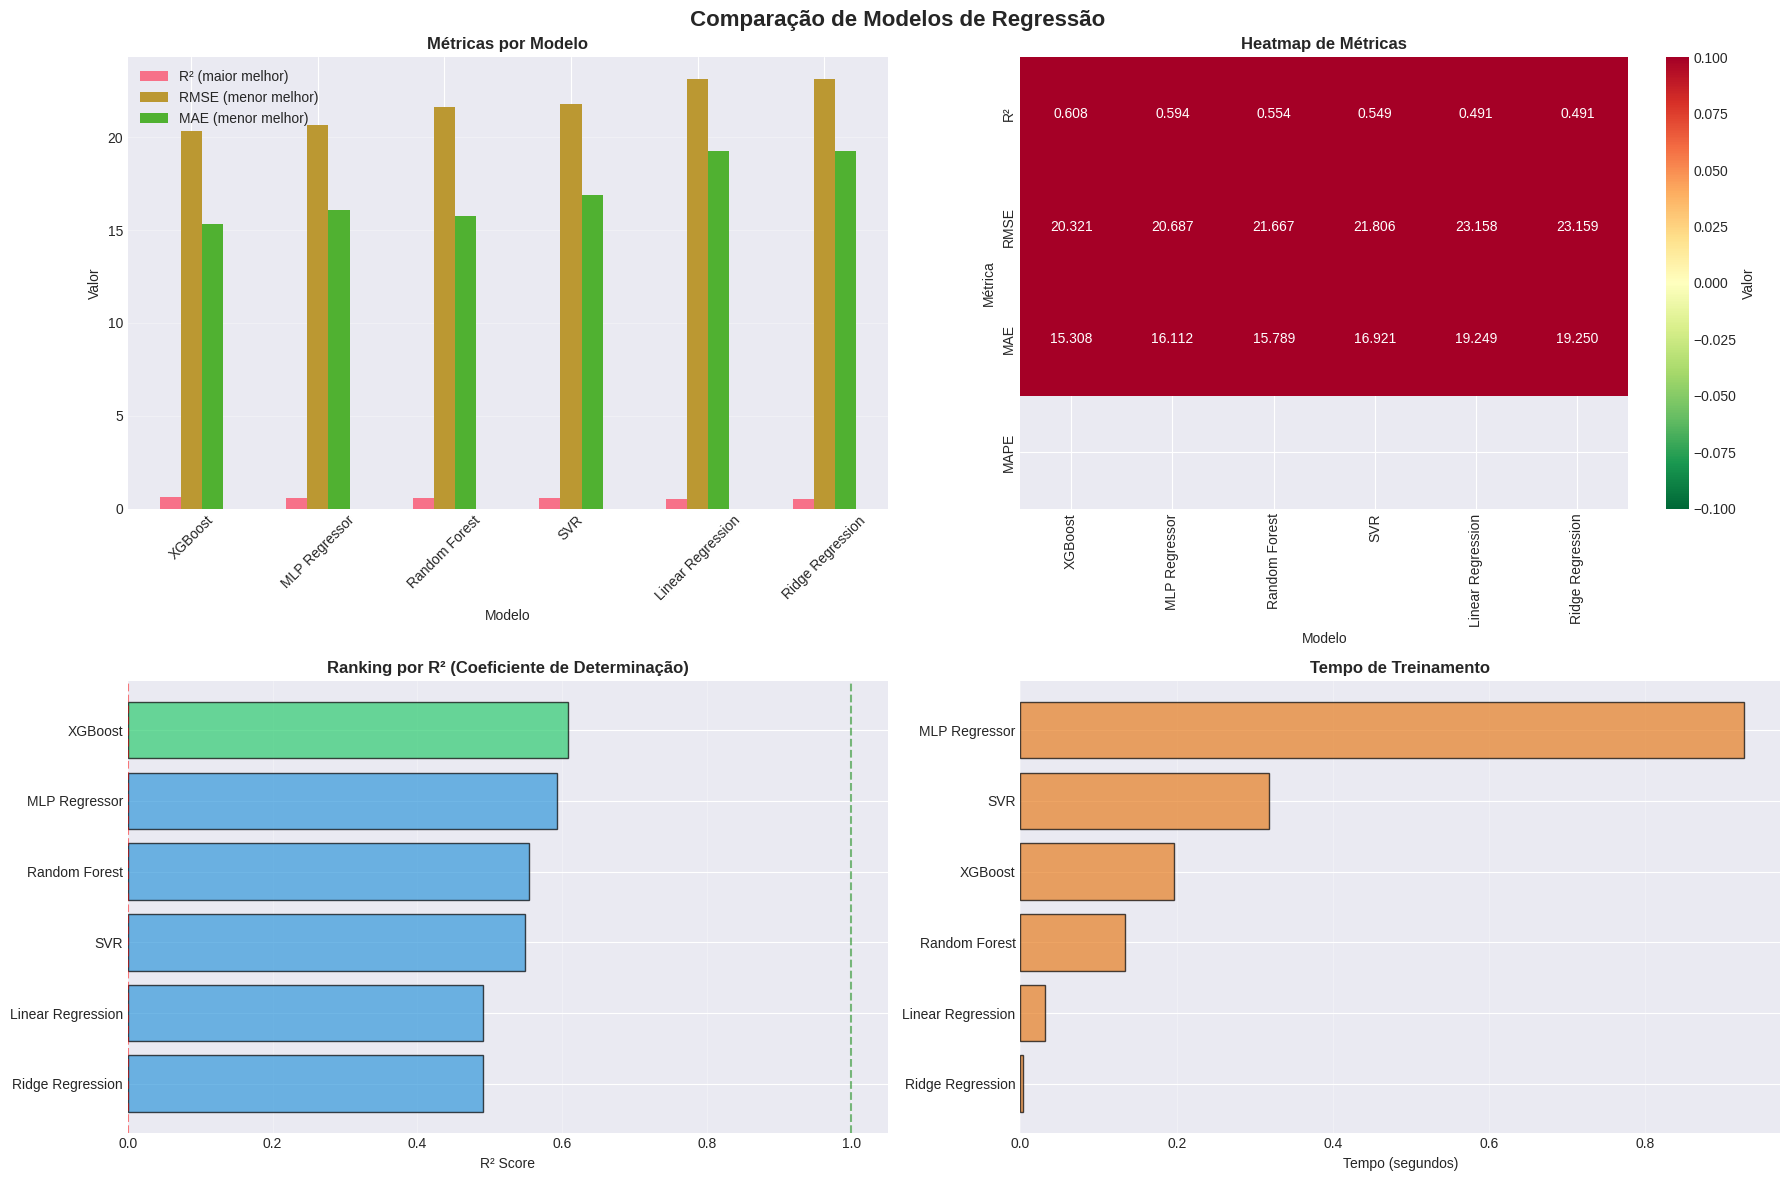


 MELHOR MODELO: XGBoost
    R²: 0.6080
    RMSE: 20.32 pontos
    MAE: 15.31 pontos
    MAPE: inf%
    Tempo: 0.20s

 Interpretação:
   - O modelo erra em média 15.3 pontos
   - Explica 60.8% da variação das notas


In [39]:
df_resultados_reg = pd.DataFrame(resultados_reg).T
df_resultados_reg['tempo'] = pd.Series(tempos_treinamento_reg)
df_resultados_reg = df_resultados_reg.sort_values('R²', ascending=False)

print("="*70)
print(" COMPARAÇÃO DOS MODELOS DE REGRESSÃO")
print("="*70)
print(df_resultados_reg.round(4))

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(' Comparação de Modelos de Regressão', fontsize=16, fontweight='bold')

# 1. Gráfico de barras com métricas
df_resultados_reg[['R²', 'RMSE', 'MAE']].plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Métricas por Modelo', fontweight='bold')
axes[0, 0].set_xlabel('Modelo')
axes[0, 0].set_ylabel('Valor')
axes[0, 0].legend(['R² (maior melhor)', 'RMSE (menor melhor)', 'MAE (menor melhor)'])
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Heatmap das métricas
sns.heatmap(df_resultados_reg[['R²', 'RMSE', 'MAE', 'MAPE']].T, 
            annot=True, fmt='.3f', cmap='RdYlGn_r', ax=axes[0, 1], 
            cbar_kws={'label': 'Valor'})
axes[0, 1].set_title('Heatmap de Métricas', fontweight='bold')
axes[0, 1].set_xlabel('Modelo')
axes[0, 1].set_ylabel('Métrica')

# 3. Comparação R² (métrica principal)
r2_scores = df_resultados_reg['R²'].sort_values(ascending=True)
colors = ['#2ecc71' if x == r2_scores.max() else '#3498db' for x in r2_scores]
axes[1, 0].barh(r2_scores.index, r2_scores.values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('Ranking por R² (Coeficiente de Determinação)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axvline(1, color='green', linestyle='--', alpha=0.5)

# 4. Tempo de treinamento
tempos = df_resultados_reg['tempo'].sort_values()
axes[1, 1].barh(tempos.index, tempos.values, color='#e67e22', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Tempo (segundos)')
axes[1, 1].set_title('Tempo de Treinamento', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Melhor modelo
melhor_modelo_reg = df_resultados_reg.index[0]
print(f"\n MELHOR MODELO: {melhor_modelo_reg}")
print(f"    R²: {df_resultados_reg.loc[melhor_modelo_reg, 'R²']:.4f}")
print(f"    RMSE: {df_resultados_reg.loc[melhor_modelo_reg, 'RMSE']:.2f} pontos")
print(f"    MAE: {df_resultados_reg.loc[melhor_modelo_reg, 'MAE']:.2f} pontos")
print(f"    MAPE: {df_resultados_reg.loc[melhor_modelo_reg, 'MAPE']:.2f}%")
print(f"    Tempo: {df_resultados_reg.loc[melhor_modelo_reg, 'tempo']:.2f}s")

print("\n Interpretação:")
print(f"   - O modelo erra em média {df_resultados_reg.loc[melhor_modelo_reg, 'MAE']:.1f} pontos")
print(f"   - Explica {df_resultados_reg.loc[melhor_modelo_reg, 'R²']*100:.1f}% da variação das notas")

### 8.4 Análise de Resíduos

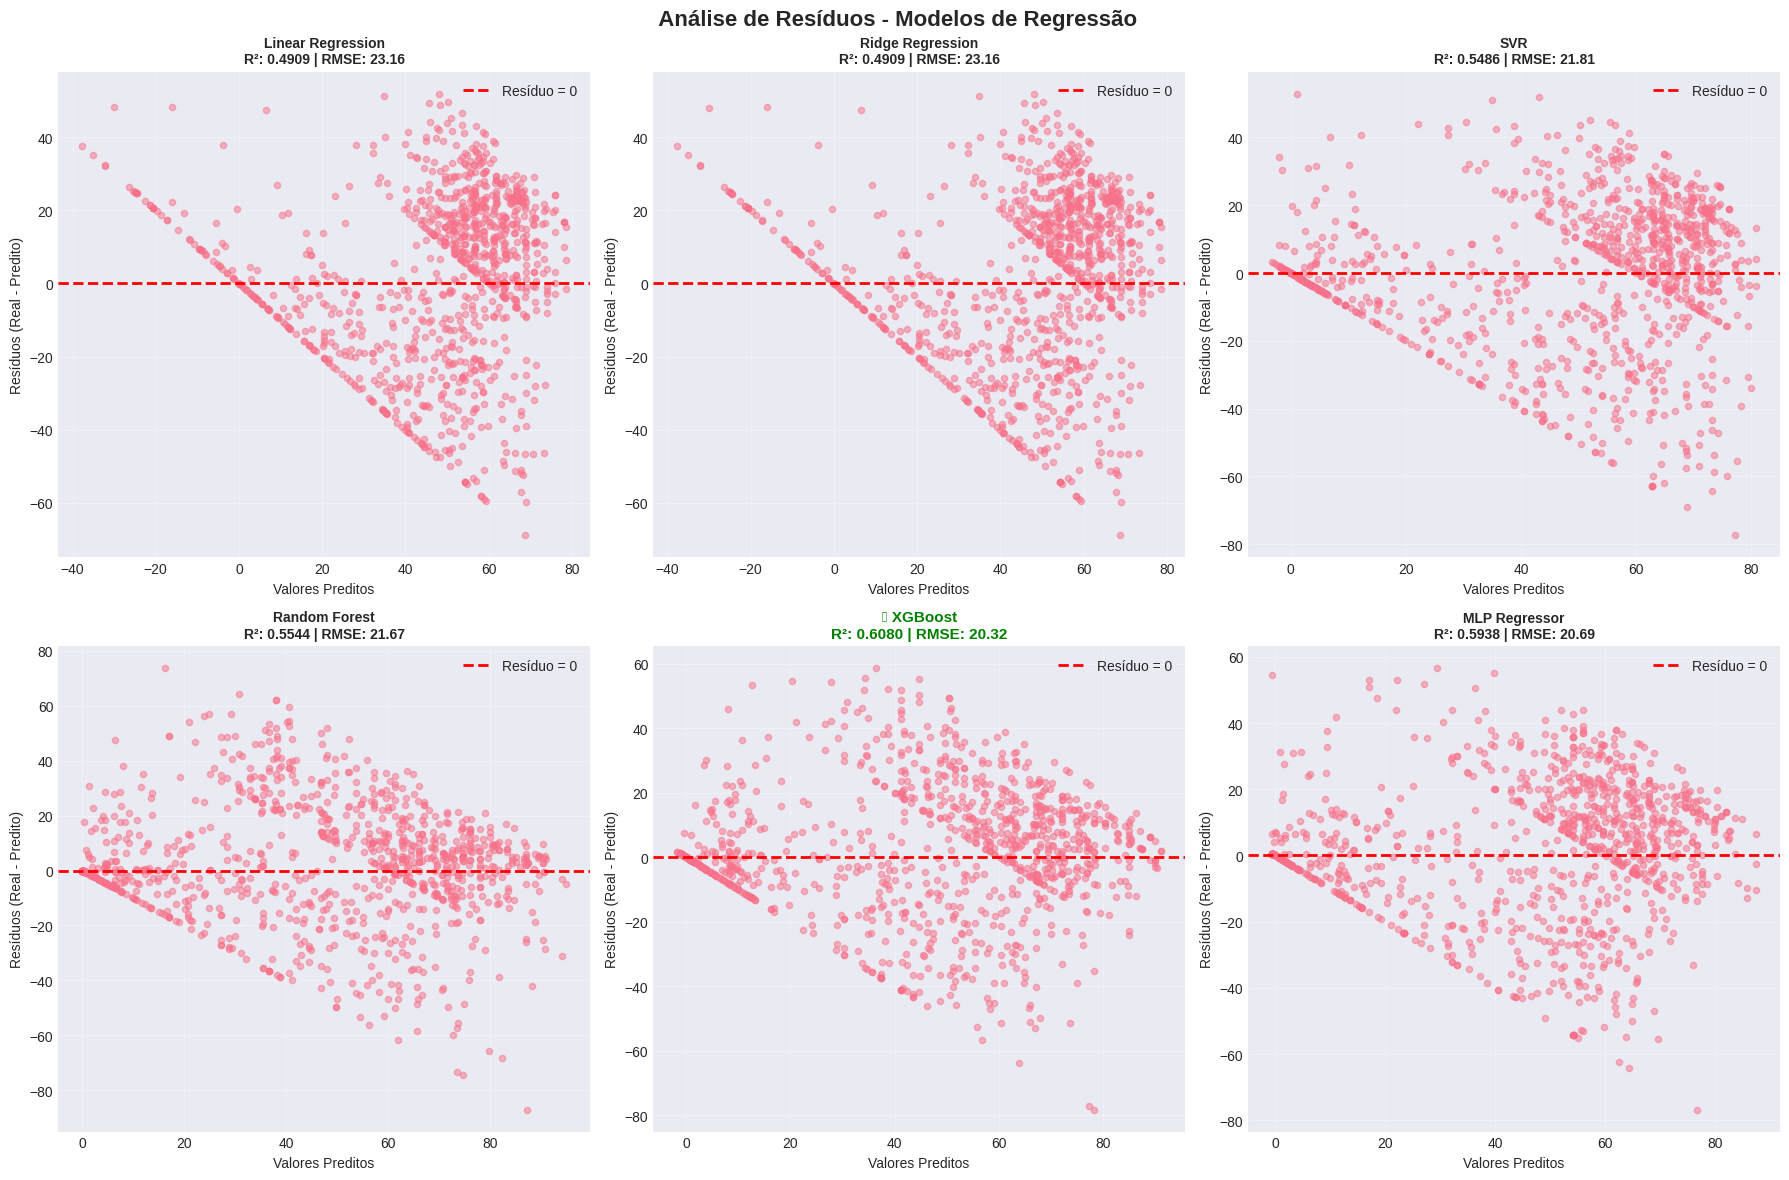


 Como interpretar os resíduos:
    Bom: Pontos distribuídos aleatoriamente em torno de zero
    Ruim: Padrões claros (curvas, tendências) indicam que o modelo não captura toda a relação


In [40]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(' Análise de Resíduos - Modelos de Regressão', fontsize=16, fontweight='bold')

predictions_reg = {
    'Linear Regression': y_pred_lin,
    'Ridge Regression': y_pred_ridge,
    'SVR': y_pred_svr,
    'Random Forest': y_pred_rf_reg,
    'XGBoost': y_pred_xgb_reg,
    'MLP Regressor': y_pred_mlp_reg
}

for idx, (nome, pred) in enumerate(predictions_reg.items()):
    ax = axes[idx // 3, idx % 3]
    residuos = y_test_r - pred
    
    # Scatter plot: Valores Preditos vs Resíduos
    ax.scatter(pred, residuos, alpha=0.5, s=20)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Resíduo = 0')
    ax.set_xlabel('Valores Preditos')
    ax.set_ylabel('Resíduos (Real - Predito)')
    
    # Destacar melhor modelo
    if nome == melhor_modelo_reg:
        ax.set_title(f'🏆 {nome}\nR²: {resultados_reg[nome]["R²"]:.4f} | RMSE: {resultados_reg[nome]["RMSE"]:.2f}', 
                    fontweight='bold', color='green', fontsize=11)
    else:
        ax.set_title(f'{nome}\nR²: {resultados_reg[nome]["R²"]:.4f} | RMSE: {resultados_reg[nome]["RMSE"]:.2f}', 
                    fontweight='bold', fontsize=10)
    
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

print("\n Como interpretar os resíduos:")
print("    Bom: Pontos distribuídos aleatoriamente em torno de zero")
print("    Ruim: Padrões claros (curvas, tendências) indicam que o modelo não captura toda a relação")

### 8.5 Predito vs Real

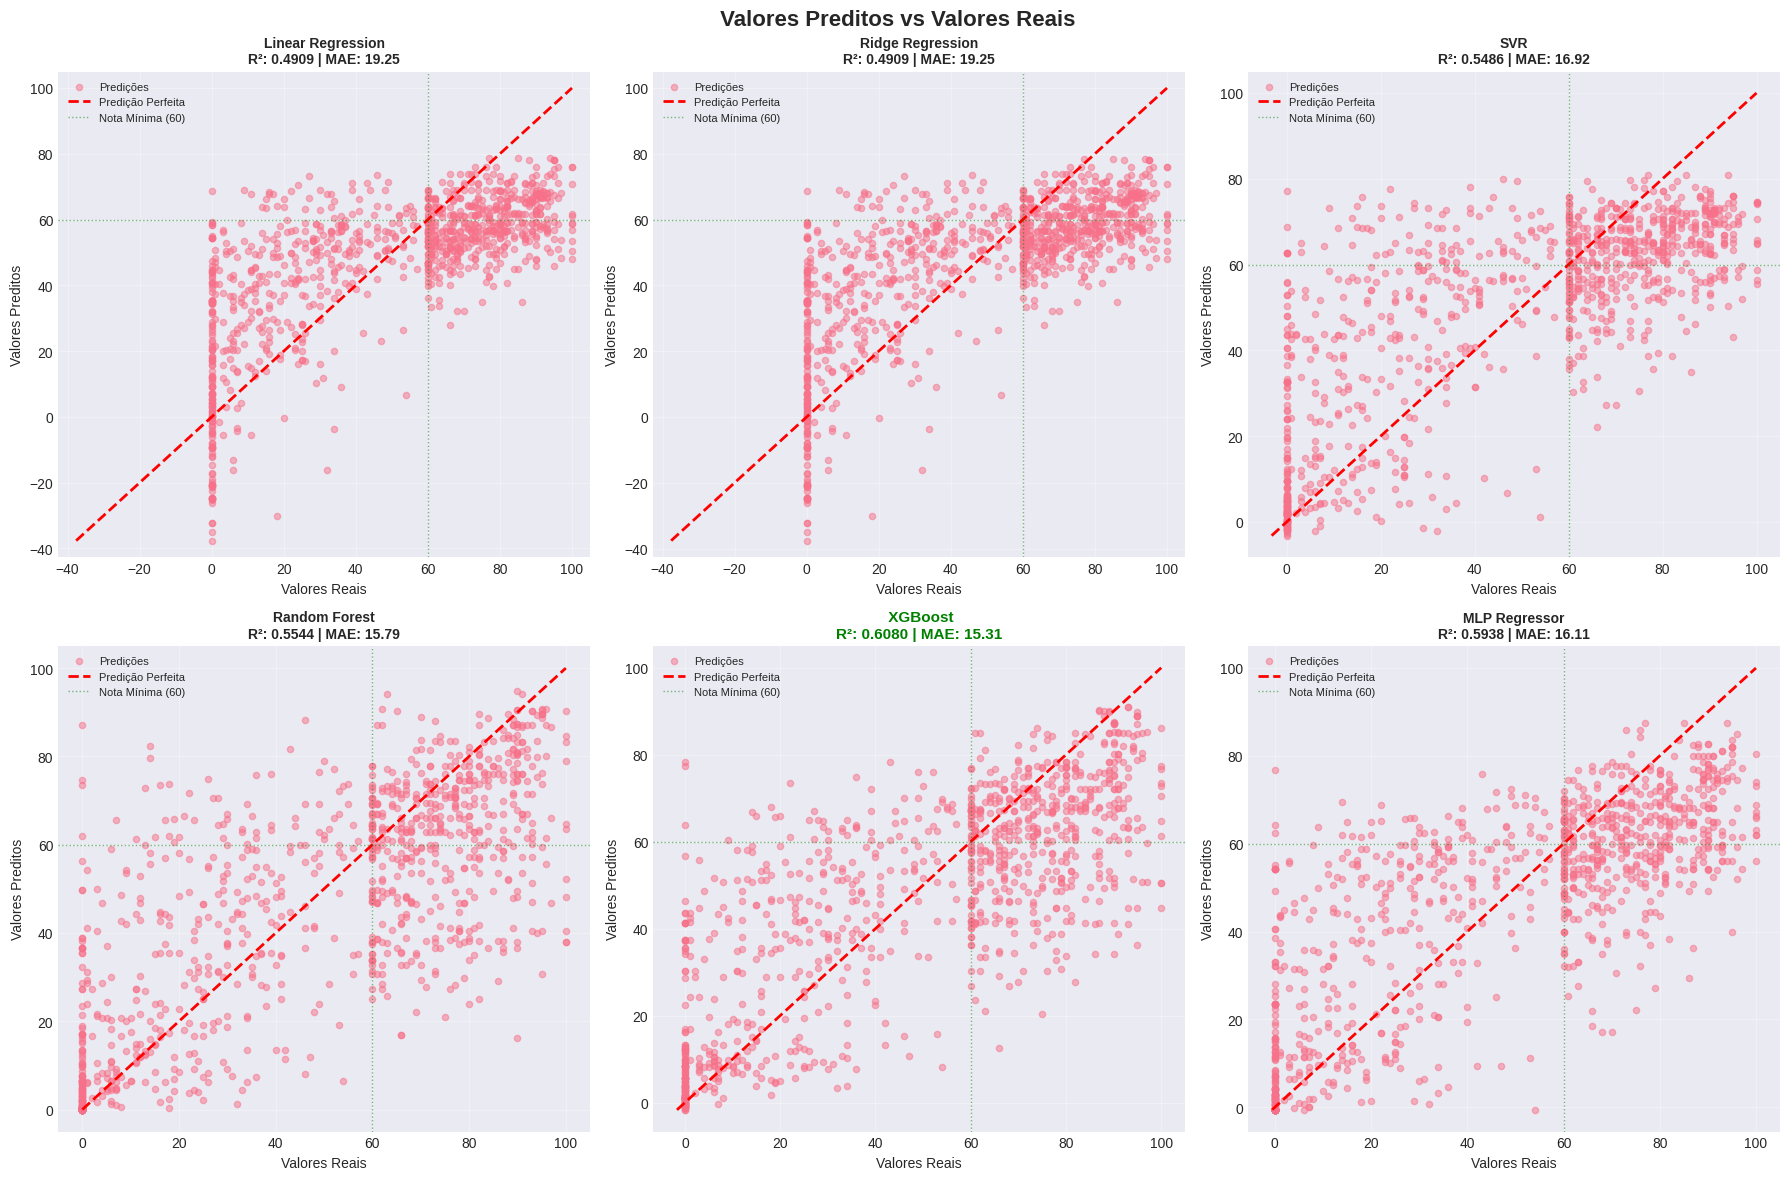


 Como interpretar:
    Quanto mais próximo da linha vermelha, melhor o modelo
    Quadrante superior direito: Aprovados preditos e reais
    Quadrante inferior esquerdo: Reprovados preditos e reais
    Quadrante superior esquerdo: Falsos positivos (previu aprovado, mas reprovou)
    Quadrante inferior direito: Falsos negativos (previu reprovado, mas aprovou)


In [42]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(' Valores Preditos vs Valores Reais', fontsize=16, fontweight='bold')

for idx, (nome, pred) in enumerate(predictions_reg.items()):
    ax = axes[idx // 3, idx % 3]
    
    # Scatter plot
    ax.scatter(y_test_r, pred, alpha=0.5, s=20, label='Predições')
    
    # Linha ideal (y = x)
    min_val = min(y_test_r.min(), pred.min())
    max_val = max(y_test_r.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predição Perfeita')
    
    # Zona de aprovação
    ax.axhline(y=60, color='green', linestyle=':', linewidth=1, alpha=0.5, label='Nota Mínima (60)')
    ax.axvline(x=60, color='green', linestyle=':', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Valores Reais')
    ax.set_ylabel('Valores Preditos')
    
    # Destacar melhor modelo
    if nome == melhor_modelo_reg:
        ax.set_title(f' {nome}\nR²: {resultados_reg[nome]["R²"]:.4f} | MAE: {resultados_reg[nome]["MAE"]:.2f}', 
                    fontweight='bold', color='green', fontsize=11)
    else:
        ax.set_title(f'{nome}\nR²: {resultados_reg[nome]["R²"]:.4f} | MAE: {resultados_reg[nome]["MAE"]:.2f}', 
                    fontweight='bold', fontsize=10)
    
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([min_val-5, max_val+5])
    ax.set_ylim([min_val-5, max_val+5])

plt.tight_layout()
plt.show()

print("\n Como interpretar:")
print("    Quanto mais próximo da linha vermelha, melhor o modelo")
print("    Quadrante superior direito: Aprovados preditos e reais")
print("    Quadrante inferior esquerdo: Reprovados preditos e reais")
print("    Quadrante superior esquerdo: Falsos positivos (previu aprovado, mas reprovou)")
print("    Quadrante inferior direito: Falsos negativos (previu reprovado, mas aprovou)")

##  9. MODELO 3: Clustering - Identificar Perfis de Alunos

### 9.1 Preparação dos Dados para Clustering

In [43]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Usar o perfil agregado por aluno (precisa ter sido criado antes)
# Selecionar features para clustering
features_cluster = ['media_nota_media', 'faltas_media', 'taxa_aprovacao', 'total_disciplinas']
X_cluster = perfil_alunos[features_cluster].copy()

# Remover possíveis NaN
X_cluster = X_cluster.dropna()
perfil_alunos_clean = perfil_alunos.loc[X_cluster.index].copy()

# Normalização é CRUCIAL para K-means
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

print("="*70)
print(" DADOS PREPARADOS PARA CLUSTERING")
print("="*70)
print(f"\n Total de alunos: {X_cluster.shape[0]}")
print(f" Features: {features_cluster}")
print(f"\n Estatísticas das features:")
print(X_cluster.describe().round(2))

 DADOS PREPARADOS PARA CLUSTERING

 Total de alunos: 781
 Features: ['media_nota_media', 'faltas_media', 'taxa_aprovacao', 'total_disciplinas']

 Estatísticas das features:
       media_nota_media  faltas_media  taxa_aprovacao  total_disciplinas
count            781.00        781.00          781.00             781.00
mean              49.82         12.89            0.55               5.27
std               26.93         13.58            0.39               2.81
min                0.00          0.00            0.00               1.00
25%               28.80          3.20            0.20               4.00
50%               54.20          8.00            0.57               5.00
75%               72.67         18.00            1.00               7.00
max              100.00         72.00            1.00              20.00


### 9.2 Método do Cotovelo (Elbow Method)

 Procurando número ótimo de clusters...


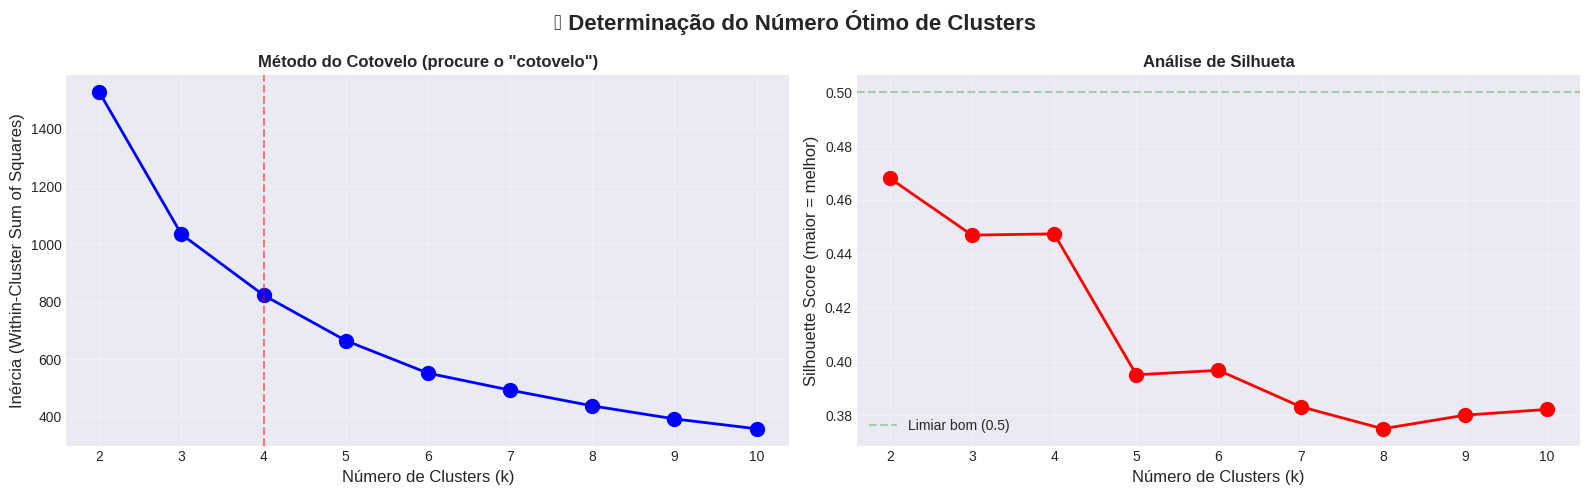


 Número ótimo sugerido (Silhouette máximo): k = 2
   Silhouette Score: 0.4680

 Recomendação: Use k=3 ou k=4 para interpretabilidade (Excelente/Bom/Ruim)


In [45]:

print(" Procurando número ótimo de clusters...")

inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# Plotar resultados
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('🔍 Determinação do Número Ótimo de Clusters', fontsize=16, fontweight='bold')

# Método do Cotovelo
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=10)
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inércia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Método do Cotovelo (procure o "cotovelo")', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Marcar ponto sugerido
cotovelo_idx = 2  # k=4 geralmente é bom para análise educacional
axes[0].axvline(K_range[cotovelo_idx], color='red', linestyle='--', alpha=0.5)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=10)
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score (maior = melhor)', fontsize=12)
axes[1].set_title('Análise de Silhueta', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0.5, color='green', linestyle='--', alpha=0.3, label='Limiar bom (0.5)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Número ótimo sugerido
k_otimo_silhouette = K_range[np.argmax(silhouette_scores)]
print(f"\n Número ótimo sugerido (Silhouette máximo): k = {k_otimo_silhouette}")
print(f"   Silhouette Score: {max(silhouette_scores):.4f}")
print(f"\n Recomendação: Use k=3 ou k=4 para interpretabilidade (Excelente/Bom/Ruim)")

### 9.3 K-means Clustering

In [52]:
# Aplicar K-means com k escolhido
k_final = 2  # Ajuste conforme análise anterior
print(f"\n Aplicando K-means com k = {k_final}")

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=20, max_iter=300)
perfil_alunos_clean['cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

# Métricas de qualidade
silhouette = silhouette_score(X_cluster_scaled, perfil_alunos_clean['cluster'])
davies_bouldin = davies_bouldin_score(X_cluster_scaled, perfil_alunos_clean['cluster'])

print(f"\n Métricas de Qualidade do Clustering:")
print(f"   • Silhouette Score: {silhouette:.4f}")
print(f"     └─ Interpretação: {('Excelente' if silhouette > 0.7 else 'Bom' if silhouette > 0.5 else 'Razoável' if silhouette > 0.25 else 'Fraco')}")
print(f"   • Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"     └─ Interpretação: {('Excelente' if davies_bouldin < 0.5 else 'Bom' if davies_bouldin < 1.0 else 'Razoável' if davies_bouldin < 1.5 else 'Fraco')}")

print(f"\n Distribuição dos clusters:")
dist = perfil_alunos_clean['cluster'].value_counts().sort_index()
for cluster_id, count in dist.items():
    print(f"   Cluster {cluster_id}: {count} alunos ({count/len(perfil_alunos_clean)*100:.1f}%)")


 Aplicando K-means com k = 2

 Métricas de Qualidade do Clustering:
   • Silhouette Score: 0.4680
     └─ Interpretação: Razoável
   • Davies-Bouldin Index: 0.8760
     └─ Interpretação: Bom

 Distribuição dos clusters:
   Cluster 0: 341 alunos (43.7%)
   Cluster 1: 440 alunos (56.3%)


### 9.4 Caracterização dos Clusters

In [53]:
cluster_stats = perfil_alunos_clean.groupby('cluster')[features_cluster].agg(['mean', 'std'])
cluster_caracteristicas = perfil_alunos_clean.groupby('cluster')[features_cluster].mean()

print("\n Características médias por cluster:")
print(cluster_caracteristicas.round(2))

def nomear_cluster_inteligente(cluster_id, stats_df):
    """
    Nomeia cluster baseado em TODAS as características
    """
    row = stats_df.loc[cluster_id]
    
    # Calcular score composto (normalizado)
    score_nota = (row['media_nota_media'] - stats_df['media_nota_media'].min()) / \
                 (stats_df['media_nota_media'].max() - stats_df['media_nota_media'].min())
    
    score_aprovacao = row['taxa_aprovacao']
    
    # Faltas: inverter (menos faltas = melhor)
    score_faltas = 1 - ((row['faltas_media'] - stats_df['faltas_media'].min()) / \
                        (stats_df['faltas_media'].max() - stats_df['faltas_media'].min()))
    
    # Score total (média ponderada)
    score_total = (score_nota * 0.4 + score_aprovacao * 0.4 + score_faltas * 0.2)
    
    return score_total, {
        'nota': row['media_nota_media'],
        'aprovacao': row['taxa_aprovacao'],
        'faltas': row['faltas_media'],
        'disciplinas': row['total_disciplinas']
    }

# Calcular scores
cluster_scores = {}
cluster_details = {}
for cluster_id in cluster_caracteristicas.index:
    score, details = nomear_cluster_inteligente(cluster_id, cluster_caracteristicas)
    cluster_scores[cluster_id] = score
    cluster_details[cluster_id] = details

# Rankear clusters por score
cluster_ranking = sorted(cluster_scores.items(), key=lambda x: x[1], reverse=True)

# Atribuir nomes baseado no ranking REAL
nomes_por_rank = [' Excelente', ' Bom', ' Regular', ' Crítico']
cluster_nomes = {}

for rank_idx, (cluster_id, score) in enumerate(cluster_ranking):
    nome = nomes_por_rank[rank_idx] if rank_idx < len(nomes_por_rank) else '❓ Outro'
    cluster_nomes[cluster_id] = nome

print("\n Perfis identificados (BASEADO NOS DADOS REAIS):")
print("="*70)

for rank_idx, (cluster_id, score) in enumerate(cluster_ranking):
    qtd = (perfil_alunos_clean['cluster'] == cluster_id).sum()
    perc = (qtd / len(perfil_alunos_clean)) * 100
    details = cluster_details[cluster_id]
    
    print(f"\n{rank_idx + 1}º LUGAR - Cluster {cluster_id}: {cluster_nomes[cluster_id]}")
    print(f"    {qtd} alunos ({perc:.1f}%)")
    print(f"    Score total: {score:.3f}")
    print(f"    Média de notas: {details['nota']:.1f}")
    print(f"    Taxa de aprovação: {details['aprovacao']:.1%}")
    print(f"    Média de faltas: {details['faltas']:.1f}")
    print(f"    Média de disciplinas: {details['disciplinas']:.1f}")

# Adicionar nomes ao dataframe
perfil_alunos_clean['cluster_nome'] = perfil_alunos_clean['cluster'].map(cluster_nomes)

print("\n" + "="*70)
print(" INTERPRETAÇÃO:")
print("="*70)
print("O K-means agrupou os alunos em 4 perfis distintos baseado em:")
print("  • Desempenho acadêmico (média de notas)")
print("  • Assiduidade (faltas)")
print("  • Consistência (taxa de aprovação)")
print("  • Engajamento (total de disciplinas)")


 Características médias por cluster:
         media_nota_media  faltas_media  taxa_aprovacao  total_disciplinas
cluster                                                                   
0                   23.89         23.30            0.16               6.16
1                   69.92          4.83            0.86               4.58

 Perfis identificados (BASEADO NOS DADOS REAIS):

1º LUGAR - Cluster 1:  Excelente
    440 alunos (56.3%)
    Score total: 0.945
    Média de notas: 69.9
    Taxa de aprovação: 86.2%
    Média de faltas: 4.8
    Média de disciplinas: 4.6

2º LUGAR - Cluster 0:  Bom
    341 alunos (43.7%)
    Score total: 0.062
    Média de notas: 23.9
    Taxa de aprovação: 15.5%
    Média de faltas: 23.3
    Média de disciplinas: 6.2

 INTERPRETAÇÃO:
O K-means agrupou os alunos em 4 perfis distintos baseado em:
  • Desempenho acadêmico (média de notas)
  • Assiduidade (faltas)
  • Consistência (taxa de aprovação)
  • Engajamento (total de disciplinas)


### 9.5 Visualização dos Clusters

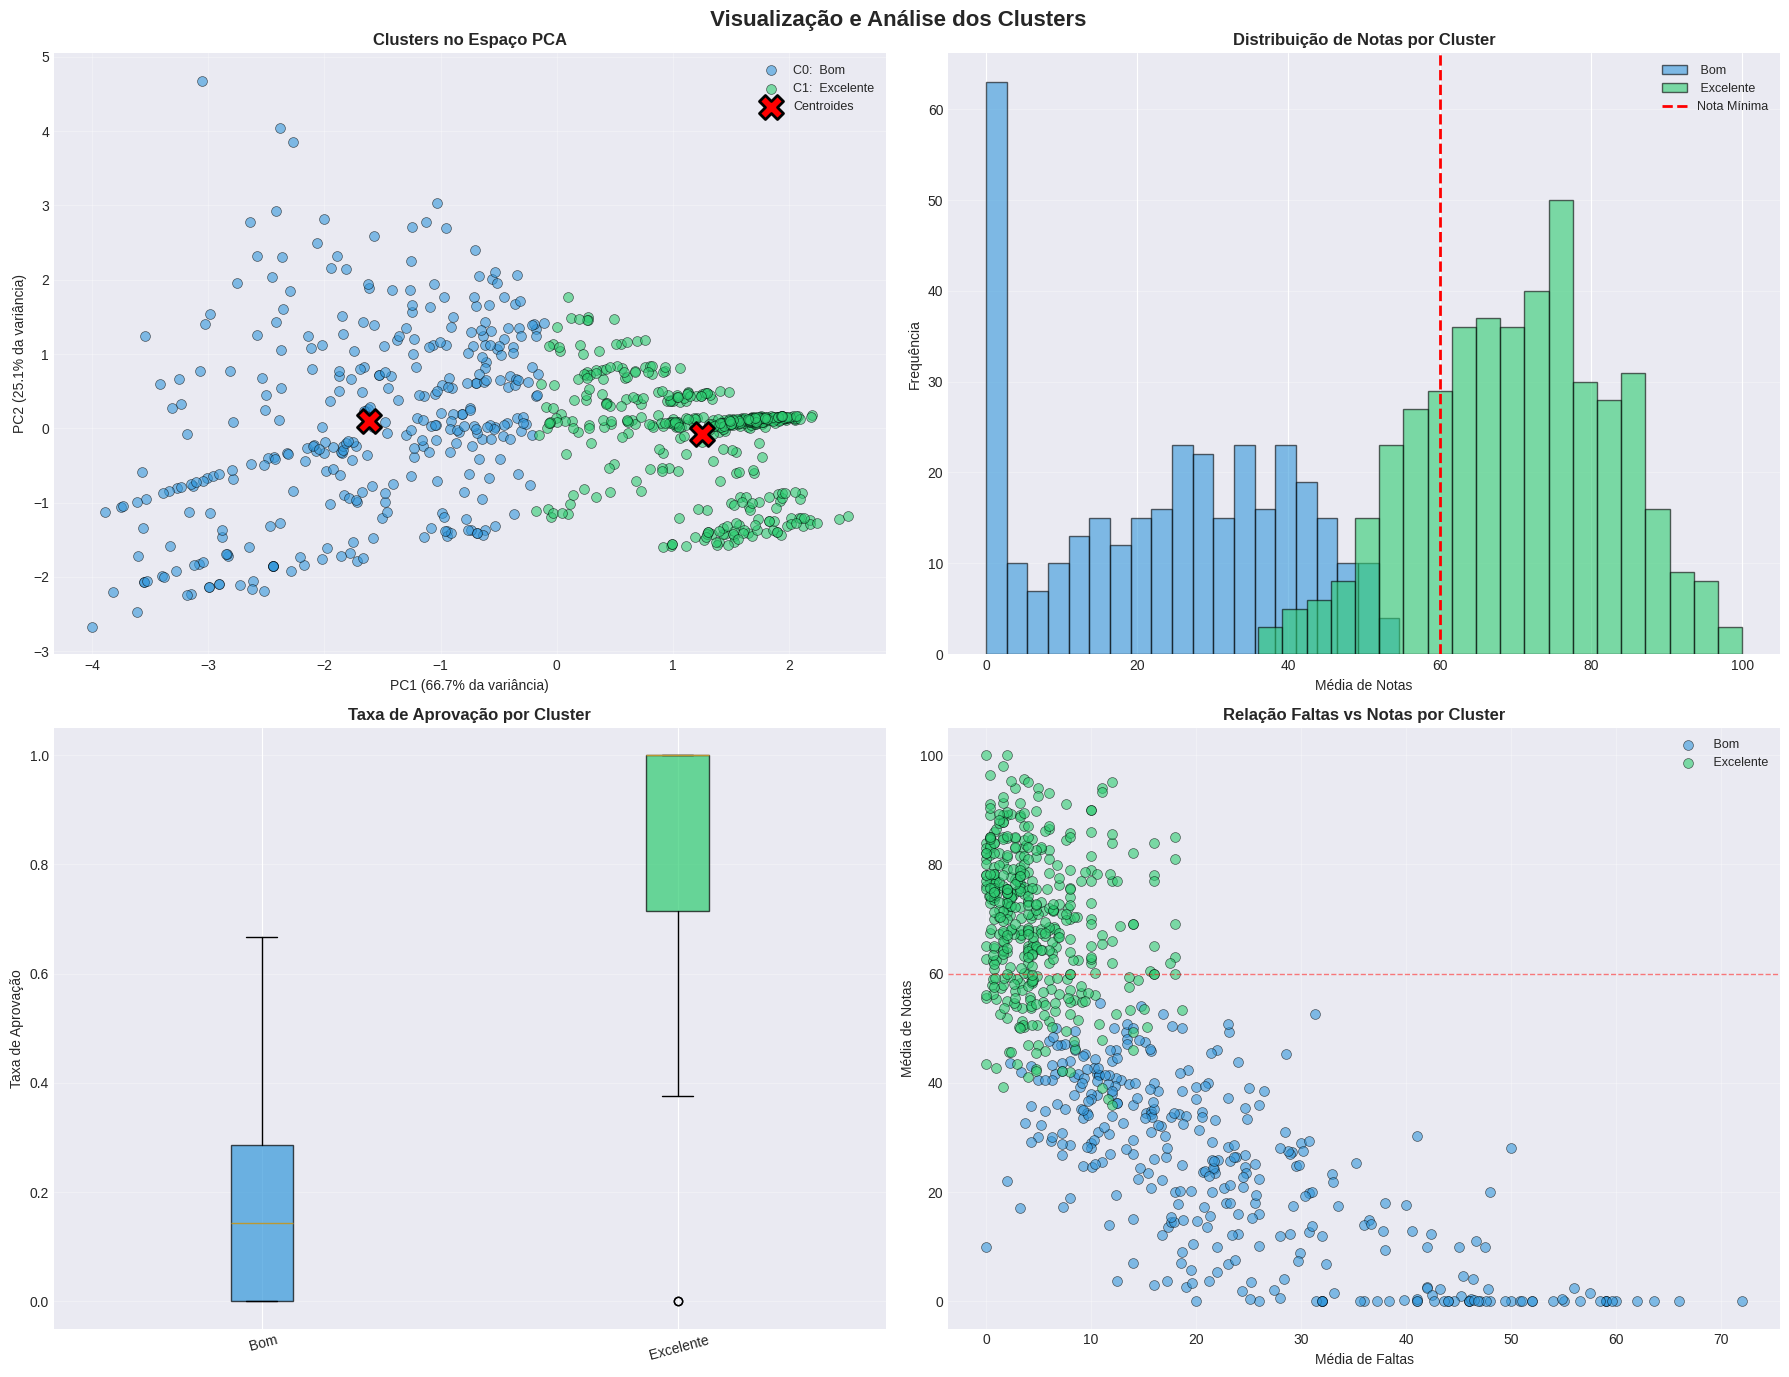

In [54]:

cores_clusters = {cluster_id: ['#2ecc71', '#3498db', '#f39c12', '#e74c3c'][idx] 
                  for idx, (cluster_id, _) in enumerate(cluster_ranking)}

# Visualização com PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster_scaled)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle(' Visualização e Análise dos Clusters', fontsize=16, fontweight='bold')

# 1. PCA Scatter
for cluster_id in sorted(perfil_alunos_clean['cluster'].unique()):
    mask = perfil_alunos_clean['cluster'] == cluster_id
    axes[0, 0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=cores_clusters[cluster_id],
                      label=f'C{cluster_id}: {cluster_nomes[cluster_id]}',
                      alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Centroides
centroides_pca = pca.transform(kmeans_final.cluster_centers_)
axes[0, 0].scatter(centroides_pca[:, 0], centroides_pca[:, 1], 
                  c='red', marker='X', s=300, edgecolors='black', linewidth=2,
                  label='Centroides', zorder=5)

axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% da variância)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% da variância)')
axes[0, 0].set_title('Clusters no Espaço PCA', fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribuição de Notas por Cluster
for cluster_id in sorted(perfil_alunos_clean['cluster'].unique()):
    dados = perfil_alunos_clean[perfil_alunos_clean['cluster'] == cluster_id]['media_nota_media']
    axes[0, 1].hist(dados, bins=20, alpha=0.6, label=f'{cluster_nomes[cluster_id]}',
                   color=cores_clusters[cluster_id], edgecolor='black')

axes[0, 1].axvline(60, color='red', linestyle='--', linewidth=2, label='Nota Mínima')
axes[0, 1].set_xlabel('Média de Notas')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição de Notas por Cluster', fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Boxplot Comparativo
data_boxplot = [perfil_alunos_clean[perfil_alunos_clean['cluster'] == c]['taxa_aprovacao'].values
                for c in sorted(perfil_alunos_clean['cluster'].unique())]
bp = axes[1, 0].boxplot(data_boxplot, labels=[cluster_nomes[c] for c in sorted(perfil_alunos_clean['cluster'].unique())],
                        patch_artist=True)

for patch, cluster_id in zip(bp['boxes'], sorted(perfil_alunos_clean['cluster'].unique())):
    patch.set_facecolor(cores_clusters[cluster_id])
    patch.set_alpha(0.7)

axes[1, 0].set_ylabel('Taxa de Aprovação')
axes[1, 0].set_title('Taxa de Aprovação por Cluster', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=15)

# 4. Scatter: Notas vs Faltas
for cluster_id in sorted(perfil_alunos_clean['cluster'].unique()):
    dados = perfil_alunos_clean[perfil_alunos_clean['cluster'] == cluster_id]
    axes[1, 1].scatter(dados['faltas_media'], dados['media_nota_media'],
                      c=cores_clusters[cluster_id], label=cluster_nomes[cluster_id],
                      alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

axes[1, 1].axhline(60, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Média de Faltas')
axes[1, 1].set_ylabel('Média de Notas')
axes[1, 1].set_title('Relação Faltas vs Notas por Cluster', fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

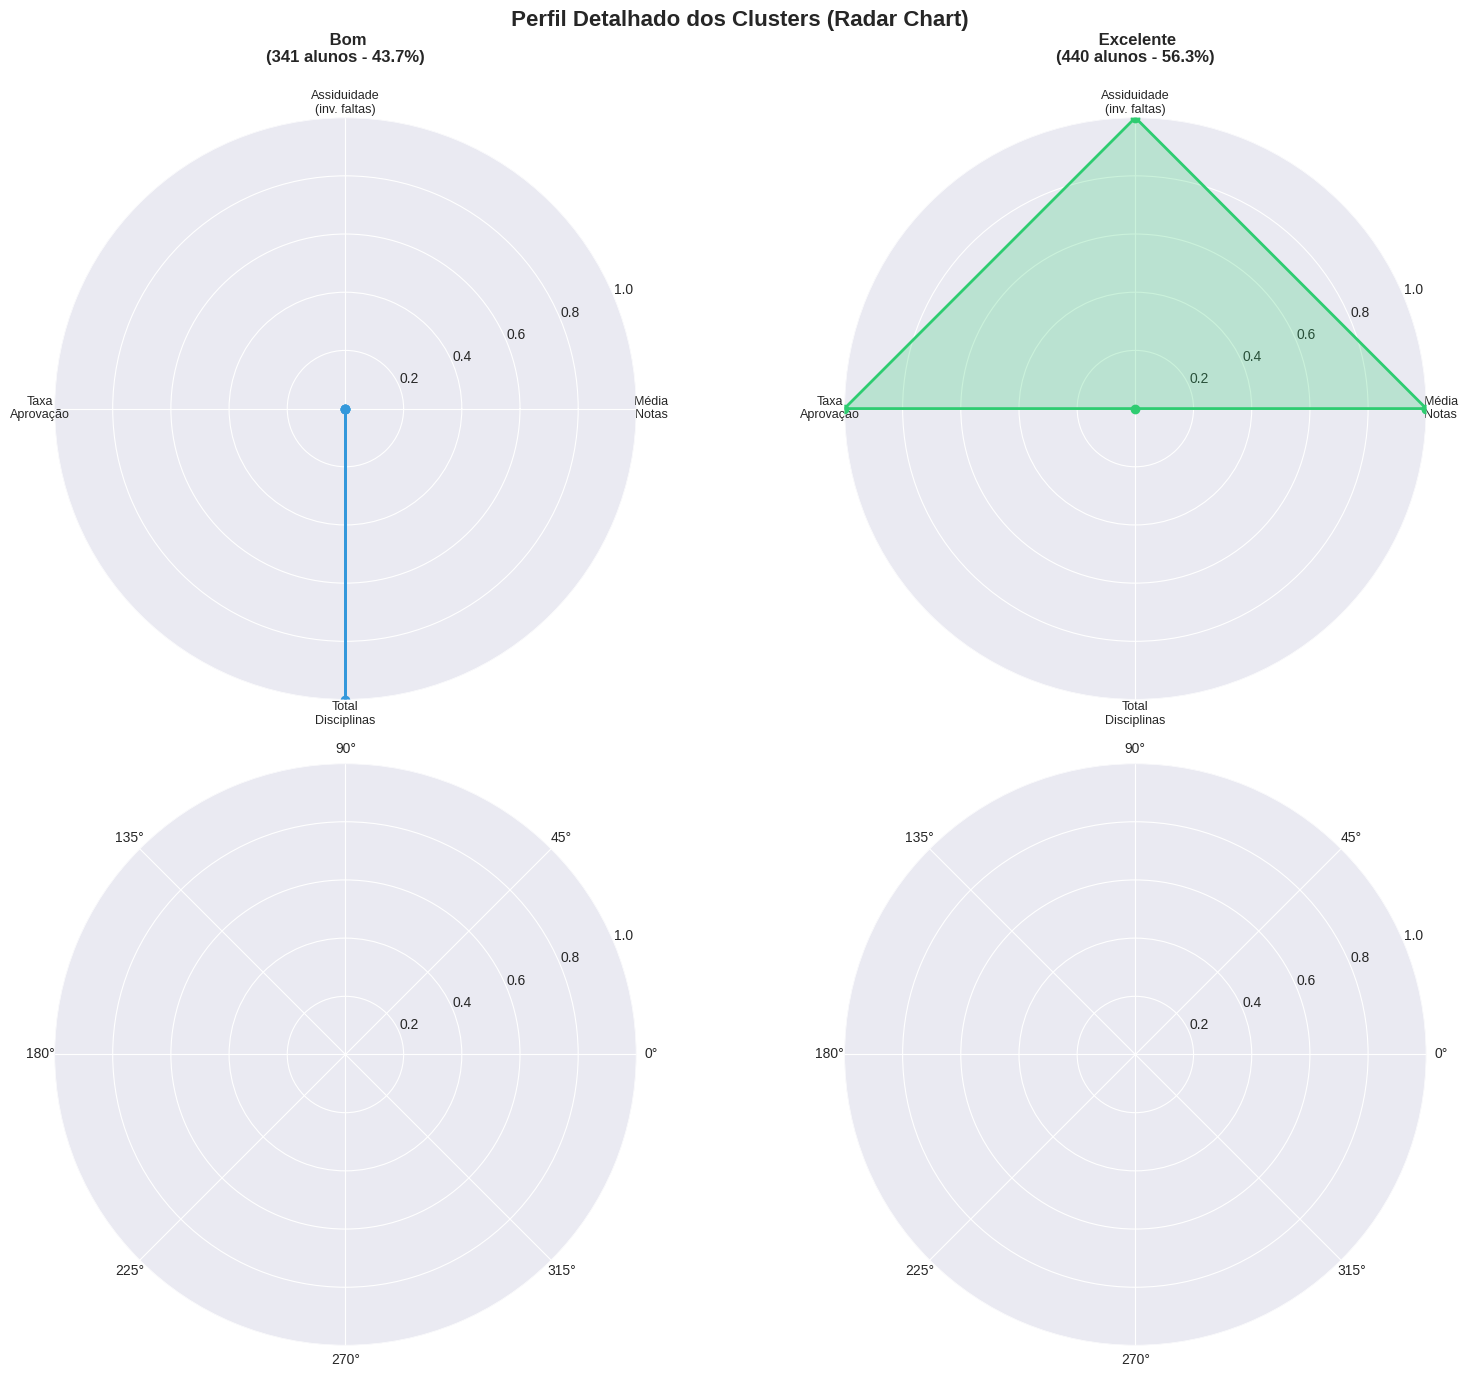

In [58]:

fig, axes = plt.subplots(2, 2, figsize=(16, 14), subplot_kw=dict(projection='polar'))
fig.suptitle(' Perfil Detalhado dos Clusters (Radar Chart)', fontsize=16, fontweight='bold')

# Normalizar features para o radar chart (0-1)
cluster_caracteristicas_norm = cluster_caracteristicas.copy()
for col in cluster_caracteristicas_norm.columns:
    max_val = cluster_caracteristicas_norm[col].max()
    min_val = cluster_caracteristicas_norm[col].min()
    if max_val > min_val:
        cluster_caracteristicas_norm[col] = (
            (cluster_caracteristicas_norm[col] - min_val) / (max_val - min_val)
        )
    else:
        cluster_caracteristicas_norm[col] = 0.5

# Inverter faltas (menos faltas = melhor)
cluster_caracteristicas_norm['faltas_media'] = 1 - cluster_caracteristicas_norm['faltas_media']

# Labels mais claros
categorias_labels = ['Média\nNotas', 'Assiduidade\n(inv. faltas)', 'Taxa\nAprovação', 'Total\nDisciplinas']
num_vars = len(features_cluster)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

for idx, cluster_id in enumerate(sorted(perfil_alunos_clean['cluster'].unique())):
    ax = axes[idx // 2, idx % 2]
    
    valores = cluster_caracteristicas_norm.loc[cluster_id].values.tolist()
    valores += valores[:1]
    
    ax.plot(angles, valores, 'o-', linewidth=2, color=cores_clusters[cluster_id])
    ax.fill(angles, valores, alpha=0.25, color=cores_clusters[cluster_id])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categorias_labels, size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f'{cluster_nomes[cluster_id]}\n'
                f'({(perfil_alunos_clean["cluster"] == cluster_id).sum()} alunos - '
                f'{(perfil_alunos_clean["cluster"] == cluster_id).sum()/len(perfil_alunos_clean)*100:.1f}%)', 
                fontweight='bold', size=12, pad=20)
    ax.grid(True)

plt.tight_layout()
plt.show()

##  10. CONCLUSÕES E INSIGHTS

In [66]:

print("="*70)
print(" RESUMO EXECUTIVO - ANÁLISE DE DESEMPENHO ACADÊMICO")
print("="*70)

print("\n" + "="*70)
print(" 1. PANORAMA GERAL DOS DADOS")
print("="*70)
print(f"    Total de registros analisados: {len(df_normal):,}")
print(f"    Total de alunos únicos: {df_normal['MATR_ALUNO'].nunique():,}")
print(f"    Total de disciplinas: {df_normal['DISCIPLINA'].nunique()}")
print(f"    Período analisado: {df_normal['ANO'].min()} - {df_normal['ANO'].max()}")

print("\n" + "="*70)
print(" 2. INDICADORES DE DESEMPENHO")
print("="*70)
taxa_aprovacao = df_normal['APROVADO'].mean() * 100
print(f"    Taxa geral de aprovação: {taxa_aprovacao:.1f}%")
print(f"      └─   CRÍTICO: Mais de {100-taxa_aprovacao:.0f}% dos alunos reprovam!")

print(f"\n    Média geral de notas: {df_normal['MEDIA_FINAL'].mean():.1f}/100")
print(f"      └─ Nota mínima para aprovação: 60.0")
print(f"      └─ Distância da média até aprovação: {60 - df_normal['MEDIA_FINAL'].mean():.1f} pontos")

print(f"\n    Média geral de faltas: {df_normal['NUM_FALTAS'].mean():.1f} faltas/aluno")
print(f"      └─ Mediana: {df_normal['NUM_FALTAS'].median():.0f} faltas")
print(f"      └─ Máximo observado: {df_normal['NUM_FALTAS'].max():.0f} faltas")

print(f"\n    Correlação Nota x Faltas: {df_normal[['MEDIA_FINAL', 'NUM_FALTAS']].corr().iloc[0,1]:.3f}")
print(f"      └─ Interpretação: Correlação negativa FORTE")
print(f"      └─ Cada falta adicional reduz ~{abs(df_normal[['MEDIA_FINAL', 'NUM_FALTAS']].corr().iloc[0,1] * df_normal['MEDIA_FINAL'].std() / df_normal['NUM_FALTAS'].std()):.1f} pontos na média")


 RESUMO EXECUTIVO - ANÁLISE DE DESEMPENHO ACADÊMICO

 1. PANORAMA GERAL DOS DADOS
    Total de registros analisados: 4,115
    Total de alunos únicos: 781
    Total de disciplinas: 5
    Período analisado: 2013 - 2017

 2. INDICADORES DE DESEMPENHO
    Taxa geral de aprovação: 50.5%
      └─   CRÍTICO: Mais de 50% dos alunos reprovam!

    Média geral de notas: 47.0/100
      └─ Nota mínima para aprovação: 60.0
      └─ Distância da média até aprovação: 13.0 pontos

    Média geral de faltas: 12.9 faltas/aluno
      └─ Mediana: 7 faltas
      └─ Máximo observado: 78 faltas

    Correlação Nota x Faltas: -0.632
      └─ Interpretação: Correlação negativa FORTE
      └─ Cada falta adicional reduz ~1.3 pontos na média


In [65]:

print("\n" + "="*70)
print(" 3. MODELOS DE CLASSIFICAÇÃO - Prever Aprovação/Reprovação")
print("="*70)
print(f"    Objetivo: Prever se aluno será APROVADO com base em FALTAS")
print(f"\n    Melhor modelo: {melhor_modelo_class}")
print(f"      • Acurácia: {df_resultados_class.loc[melhor_modelo_class, 'accuracy']*100:.2f}%")
print(f"      • Precisão: {df_resultados_class.loc[melhor_modelo_class, 'precision']*100:.2f}%")
print(f"      • Recall: {df_resultados_class.loc[melhor_modelo_class, 'recall']*100:.2f}%")
print(f"      • F1-Score: {df_resultados_class.loc[melhor_modelo_class, 'f1']:.4f}")
print(f"      • Tempo de treinamento: {df_resultados_class.loc[melhor_modelo_class, 'tempo']:.2f}s")

print(f"\n    Comparação com baseline:")
print(f"      • Baseline (sempre prever aprovado): {taxa_aprovacao:.1f}%")
print(f"      • Melhoria do modelo: +{df_resultados_class.loc[melhor_modelo_class, 'accuracy']*100 - taxa_aprovacao:.1f} pontos percentuais")

print(f"\n    Top 3 modelos:")
for idx, (modelo, row) in enumerate(df_resultados_class.head(3).iterrows(), 1):
    print(f"      {idx}. {modelo}: {row['f1']:.4f} F1-Score")

print("\n" + "="*70)
print(" 4. MODELOS DE REGRESSÃO - Prever Nota Final")
print("="*70)
print(f"    Objetivo: Estimar qual será a NOTA FINAL com base em FALTAS")
print(f"\n    Melhor modelo: {melhor_modelo_reg}")
print(f"      • R² (coef. determinação): {df_resultados_reg.loc[melhor_modelo_reg, 'R²']:.4f}")
print(f"        └─ Explica {df_resultados_reg.loc[melhor_modelo_reg, 'R²']*100:.1f}% da variação das notas")
print(f"      • RMSE: {df_resultados_reg.loc[melhor_modelo_reg, 'RMSE']:.2f} pontos")
print(f"      • MAE: {df_resultados_reg.loc[melhor_modelo_reg, 'MAE']:.2f} pontos")
print(f"        └─ Erro médio: ±{df_resultados_reg.loc[melhor_modelo_reg, 'MAE']:.1f} pontos na previsão")
print(f"      • MAPE: {df_resultados_reg.loc[melhor_modelo_reg, 'MAPE']:.1f}%")
print(f"      • Tempo de treinamento: {df_resultados_reg.loc[melhor_modelo_reg, 'tempo']:.2f}s")

print(f"\n    Top 3 modelos:")
for idx, (modelo, row) in enumerate(df_resultados_reg.head(3).iterrows(), 1):
    print(f"      {idx}. {modelo}: R²={row['R²']:.4f}, RMSE={row['RMSE']:.2f}")



 3. MODELOS DE CLASSIFICAÇÃO - Prever Aprovação/Reprovação
    Objetivo: Prever se aluno será APROVADO com base em FALTAS

    Melhor modelo: SVM RBF
      • Acurácia: 80.08%
      • Precisão: 75.08%
      • Recall: 90.56%
      • F1-Score: 0.8210
      • Tempo de treinamento: 0.33s

    Comparação com baseline:
      • Baseline (sempre prever aprovado): 50.5%
      • Melhoria do modelo: +29.6 pontos percentuais

    Top 3 modelos:
      1. SVM RBF: 0.8210 F1-Score
      2. SVM Linear: 0.8151 F1-Score
      3. Random Forest: 0.8111 F1-Score

 4. MODELOS DE REGRESSÃO - Prever Nota Final
    Objetivo: Estimar qual será a NOTA FINAL com base em FALTAS

    Melhor modelo: XGBoost
      • R² (coef. determinação): 0.6080
        └─ Explica 60.8% da variação das notas
      • RMSE: 20.32 pontos
      • MAE: 15.31 pontos
        └─ Erro médio: ±15.3 pontos na previsão
      • MAPE: inf%
      • Tempo de treinamento: 0.20s

    Top 3 modelos:
      1. XGBoost: R²=0.6080, RMSE=20.32
      2. ML

In [64]:
print("\n" + "="*70)
print(" 5. CLUSTERING - Identificação de Perfis de Alunos")
print("="*70)
print(f"    Método: K-means com {k_final} clusters")
print(f"    Qualidade do agrupamento:")
print(f"      • Silhouette Score: {silhouette:.4f}")
silhouette_interpretacao = "Excelente" if silhouette > 0.7 else "Bom" if silhouette > 0.5 else "Razoável" if silhouette > 0.25 else "Fraco"
print(f"        └─ {silhouette_interpretacao}")
print(f"      • Davies-Bouldin Index: {davies_bouldin:.4f}")

print(f"\n     Perfis identificados:")
# Usar o ranking correto
for rank_idx, (cluster_id, score) in enumerate(cluster_ranking):
    qtd = (perfil_alunos_clean['cluster'] == cluster_id).sum()
    perc = (qtd / len(perfil_alunos_clean)) * 100
    details = cluster_details[cluster_id]
    
    print(f"\n      {rank_idx + 1}. {cluster_nomes[cluster_id]} (Cluster {cluster_id})")
    print(f"         • Alunos: {qtd} ({perc:.1f}%)")
    print(f"         • Média de notas: {details['nota']:.1f}")
    print(f"         • Taxa de aprovação: {details['aprovacao']*100:.1f}%")
    print(f"         • Média de faltas: {details['faltas']:.1f}")

print("\n" + "="*70)
print(" 6. PRINCIPAIS INSIGHTS E DESCOBERTAS")
print("="*70)

# Calcular insights dinâmicos
reprovados_freq = len(df_normal[df_normal['TIPO_SITUACAO'] == 'Reprovado por Frequência'])
perc_reprov_freq = (reprovados_freq / len(df_normal)) * 100

print(f"\n    ALERTAS CRÍTICOS:")
print(f"      • {100-taxa_aprovacao:.0f}% de taxa de reprovação é MUITO ALTA")
print(f"      • {perc_reprov_freq:.1f}% reprovam por FREQUÊNCIA (absenteísmo)")
print(f"      • Média geral ({df_normal['MEDIA_FINAL'].mean():.1f}) está {60-df_normal['MEDIA_FINAL'].mean():.1f} pontos abaixo da aprovação")

print(f"\n    FATORES DE SUCESSO:")
print(f"      • Faltas são o MAIOR preditor de reprovação (corr: {df_normal[['MEDIA_FINAL', 'NUM_FALTAS']].corr().iloc[0,1]:.3f})")
print(f"      • Modelos conseguem prever com {df_resultados_class.loc[melhor_modelo_class, 'accuracy']*100:.1f}% de acurácia")
print(f"      • {(perfil_alunos_clean['cluster'] == cluster_ranking[0][0]).sum()} alunos ({(perfil_alunos_clean['cluster'] == cluster_ranking[0][0]).sum()/len(perfil_alunos_clean)*100:.1f}%) no perfil Excelente")

print(f"\n    PADRÕES IDENTIFICADOS:")
aprovados = df_normal[df_normal['APROVADO'] == 1]
reprovados = df_normal[df_normal['APROVADO'] == 0]
print(f"      • Aprovados: {aprovados['NUM_FALTAS'].mean():.1f} faltas em média")
print(f"      • Reprovados: {reprovados['NUM_FALTAS'].mean():.1f} faltas em média")
print(f"      • Diferença: {reprovados['NUM_FALTAS'].mean() - aprovados['NUM_FALTAS'].mean():.1f} faltas a mais")


 5. CLUSTERING - Identificação de Perfis de Alunos
    Método: K-means com 2 clusters
    Qualidade do agrupamento:
      • Silhouette Score: 0.4680
        └─ Razoável
      • Davies-Bouldin Index: 0.8760

     Perfis identificados:

      1.  Excelente (Cluster 1)
         • Alunos: 440 (56.3%)
         • Média de notas: 69.9
         • Taxa de aprovação: 86.2%
         • Média de faltas: 4.8

      2.  Bom (Cluster 0)
         • Alunos: 341 (43.7%)
         • Média de notas: 23.9
         • Taxa de aprovação: 15.5%
         • Média de faltas: 23.3

 6. PRINCIPAIS INSIGHTS E DESCOBERTAS

    ALERTAS CRÍTICOS:
      • 50% de taxa de reprovação é MUITO ALTA
      • 22.4% reprovam por FREQUÊNCIA (absenteísmo)
      • Média geral (47.0) está 13.0 pontos abaixo da aprovação

    FATORES DE SUCESSO:
      • Faltas são o MAIOR preditor de reprovação (corr: -0.632)
      • Modelos conseguem prever com 80.1% de acurácia
      • 440 alunos (56.3%) no perfil Excelente

    PADRÕES IDENTIFICADO

##  11. Exportar Resultados

In [68]:

# 1. Resultados de classificação
df_resultados_class.to_csv('resultados_classificacao.csv')

# 2. Resultados de regressão
df_resultados_reg.to_csv('resultados_regressao.csv')

# 3. Perfil de alunos com clusters (CORRIGIDO)
perfil_alunos_clean.to_csv('perfil_alunos_clusters.csv', index=False)

# 4. Dataset limpo usado na modelagem
df_normal.to_csv('dataset_limpo.csv', index=False)

# 5. Estatísticas por disciplina (CRIAR E SALVAR)
disciplina_stats = df_normal.groupby('DISCIPLINA').agg({
    'MATR_ALUNO': 'count',
    'APROVADO': 'mean',
    'MEDIA_FINAL': 'mean',
    'NUM_FALTAS': 'mean'
}).reset_index()
disciplina_stats.columns = ['DISCIPLINA', 'Total_Matriculas', 'Taxa_Aprovacao', 'Media_Nota', 'Media_Faltas']
disciplina_stats['Taxa_Aprovacao'] = (disciplina_stats['Taxa_Aprovacao'] * 100).round(1)
disciplina_stats = disciplina_stats.sort_values('Taxa_Aprovacao', ascending=False)
disciplina_stats.to_csv('estatisticas_disciplinas.csv', index=False)

# 6. Estatísticas temporais
temporal_stats.to_csv('estatisticas_temporais.csv', index=False)

# 7. Características dos clusters
cluster_summary = perfil_alunos_clean.groupby('cluster').agg({
    'media_nota_media': ['mean', 'std'],
    'faltas_media': ['mean', 'std'],
    'taxa_aprovacao': ['mean', 'std'],
    'total_disciplinas': ['mean', 'std'],
    'MATR_ALUNO': 'count'
})
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary['cluster_nome'] = cluster_summary.index.map(cluster_nomes)
cluster_summary.to_csv('clusters_caracteristicas.csv')